In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from prettytable import PrettyTable
import csv
import math
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgbc

In [2]:
# https://github.com/pandas-dev/pandas/issues/11493
# https://stackoverflow.com/questions/52105659/pandas-read-csv-unexpected-end-of-data-error

project_data = pd.read_csv('train_data.csv', engine='python', error_bad_lines=False)
resource_data = pd.read_csv('resources.csv', engine='python', error_bad_lines=False)

In [3]:
# https://stackoverflow.com/questions/41581044/pandas-aggregate-rows-for-a-given-column-and-count-the-number

rd = resource_data.groupby('id').description
rd = rd.agg(dict(description = lambda x:list(x), number='count'))

In [4]:
price_qty_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
resource_data = pd.merge(rd, price_qty_data, on='id', how='left')

In [5]:
project_data = pd.merge(project_data, resource_data, on='id', how='left')

In [6]:
print(len(project_data))

109248


In [7]:
# https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

# https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis = 'columns', inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [8]:
# consider we have text like this "Math & Science, Warmth, Care & Hunger"
# it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
# this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
# if we have the words "The" we are going to replace it with ''(i.e removing 'The')
# we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
#" abc ".strip() will return "abc", remove the trailing spaces
# we are replacing the & value into _

def preprocess(param1):
    lst=list()
    for i in param1:
        temp=''
        for j in i.split(','):
            if 'The' in j.split():
                j=j.replace('The', '')
            j=j.replace(' ', '')
            j=j.lower()
            temp+=j.strip() + ' '
            temp = temp.replace('&', '_')
            temp = temp.replace(' ', '_')
        lst.append(temp.rstrip('_'))
    return lst

In [9]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


categories = list(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocess(categories)
#project_data.drop(['project_subject_categories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_categories'].values:
    cnt.update(word.split())

cat_dict = dict(cnt)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:kv[1]))
        

In [10]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


sub_categories = list(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocess(sub_categories)
project_data.drop(['project_subject_subcategories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_subcategories'].values:
    cnt.update(word.split())

sub_cat_dict = dict(cnt)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv:kv[1]))
        

In [11]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna("")
teacher_pfx = list(project_data['teacher_prefix'].values)

teacher_pfx_list = []
for i in teacher_pfx:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace('.','')
        j = j.lower()
        temp +=j.strip()+" "
    teacher_pfx_list.append(temp.strip()) 
    
project_data['clean_teacher_prefix'] = teacher_pfx_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:kv[1]))


In [12]:
prj_grd_cat = list(project_data['project_grade_category'].values)

prj_grd_cat_list = []
for i in prj_grd_cat:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j = j.replace('-','_')
        j = j.lower()
        temp +=j.strip()+" "
    prj_grd_cat_list.append(temp.strip()) 
    
project_data['clean_project_grade_category'] = prj_grd_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv:kv[1]))

In [13]:
state = list(project_data['school_state'].values)

state_list = []
for i in state:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j=j.lower()
        temp +=j.strip()+" "
        temp = temp.replace('&','')
    state_list.append(temp.strip()) 
    
project_data['clean_state'] = state_list

project_data.drop(['school_state'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv:kv[1]))

In [14]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [15]:
project_data.drop(["project_essay_1"], axis=1, inplace=True)
project_data.drop(["project_essay_2"], axis=1, inplace=True)
project_data.drop(["project_essay_3"], axis=1, inplace=True)
project_data.drop(["project_essay_4"], axis=1, inplace=True)

In [16]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [18]:
preprocessed_essays = list()
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['clean_essays'] = preprocessed_essays
project_data.drop('essay', axis=1, inplace=True)

100%|██████████| 109248/109248 [01:25<00:00, 1282.71it/s]


### Computing Sentiment Scores of clean_essays

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import nltk
#nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg_score = list()
neu_score = list()
pos_score = list()
compound_score = list()
for essay in tqdm(project_data['clean_essays'].values):
    ss = sid.polarity_scores(essay)
    neg_score.append(ss['neg'])
    neu_score.append(ss['neu'])
    pos_score.append(ss['pos']) 
    compound_score.append(ss['compound'])   
project_data['sentiment_score_neg'] = neg_score
project_data['sentiment_score_neu'] = neu_score
project_data['sentiment_score_pos'] = pos_score
project_data['sentiment_score_compound'] = compound_score
project_data['sentiment_score_neg'] = project_data['sentiment_score_neg'].astype(float)
project_data['sentiment_score_neu'] = project_data['sentiment_score_neu'].astype(float)
project_data['sentiment_score_pos'] = project_data['sentiment_score_pos'].astype(float)
project_data['sentiment_score_compound'] = project_data['sentiment_score_compound'].astype(float)

100%|██████████| 109248/109248 [05:09<00:00, 352.95it/s]


### Computing number of words in clean_essays

In [22]:
essay_length = list()
for essay in tqdm(project_data['clean_essays'].values):
    length = len(essay)
    essay_length.append(length)
project_data['clean_essay_length'] = essay_length
project_data['clean_essay_length'] = project_data['clean_essay_length'].astype(float)

100%|██████████| 109248/109248 [00:00<00:00, 1101192.28it/s]


In [23]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent2 = decontracted(sentence)
    sent2 = sent2.replace('\\r', ' ')
    sent2 = sent2.replace('\\"', ' ')
    sent2 = sent2.replace('\\n', ' ')
    sent2 = re.sub('[^A-Za-z0-9]+', ' ', sent2)
    # https://gist.github.com/sebleier/554280
    sent2 = ' '.join(e for e in sent2.split() if e not in stopwords)
    preprocessed_titles.append(sent2.lower().strip())
    
project_data['clean_project_title'] = preprocessed_titles
project_data.drop('project_title', axis=1, inplace=True)

100%|██████████| 109248/109248 [00:04<00:00, 27158.76it/s]


### Computing number of words in clean_project_title

In [24]:
title_length = list()
for title in tqdm(project_data['clean_project_title'].values):
    length = len(title)
    title_length.append(length)
project_data['clean_title_length'] = title_length
project_data['clean_title_length'] = project_data['clean_title_length'].astype(float)

100%|██████████| 109248/109248 [00:00<00:00, 1200161.67it/s]


In [25]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis='columns', inplace=True)
X = project_data

In [26]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [27]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M9.pickle', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [28]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M9.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [29]:
print(len(X_train))

76473


In [30]:
print(len(X_test))

32775


## Make Data Model Ready

### Vectorizing Categorical Data

#### Train clean_state column 

In [31]:
# https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
# https://stackoverflow.com/questions/16819222/how-to-return-dictionary-keys-as-a-list-in-python

train_clean_state = {'clean_state':X_train['clean_state'], 'class':y_train}
train_temp_clean_state_df = pd.DataFrame(data=train_clean_state)
train_temp_clean_state = train_temp_clean_state_df.groupby('clean_state').count().to_dict()
keys = [*train_temp_clean_state['class']]
total = [v for k, v in train_temp_clean_state['class'].items()]

train_clean_state_0 = train_temp_clean_state_df.loc[train_temp_clean_state_df['class'] == 0]
train_clean_state_zero = train_clean_state_0.groupby('clean_state').count().to_dict()
state0 = [v for k,v in train_clean_state_zero['class'].items()]

train_clean_state_1 = train_temp_clean_state_df.loc[train_temp_clean_state_df['class'] == 1]
train_clean_state_one = train_clean_state_1.groupby('clean_state').count().to_dict()
state1 = [v for k,v in train_clean_state_one['class'].items()]

train_clean_state_probability_table = pd.DataFrame({'clean_state':pd.Series(keys), \
                                                    'state=0':pd.Series(state0)/ \
                                                    pd.Series(total),\
                                                    'state=1':pd.Series(state1)/ \
                                                    pd.Series(total)})

In [32]:
X_train = pd.merge(X_train, train_clean_state_probability_table, on='clean_state', how='left')

#### Test clean_state column 

In [33]:
X_test = pd.merge(X_test, train_clean_state_probability_table, on='clean_state', how='left')

In [34]:
# if state=0 and state=1 isna = True for X_test and X_test before merge and after merge has same rows, 
# we would replace nan with 0.5 for both state=0 and state=1 column.

X_test.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

In [35]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_state_vectorized.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [36]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_state_vectorized.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [37]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_state_vectorized.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [38]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_state_vectorized.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [39]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description', 'number',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'state=0', 'state=1'],
      dtype='object')

#### Train clean_categories column

In [40]:
train_clean_clean_categories = {'clean_categories':X_train['clean_categories'], 'class':y_train}
train_temp_clean_categories_df = pd.DataFrame(data=train_clean_clean_categories)
train_temp_clean_categories = train_temp_clean_categories_df.groupby('clean_categories').count().to_dict()
keys_total = [*train_temp_clean_categories['class']]
total = [v for k, v in train_temp_clean_categories['class'].items()]

In [41]:
total_prob = pd.DataFrame({'clean_categories':pd.Series(keys_total), \
                           'Total':pd.Series(total)})

In [42]:
train_clean_categories_0 = train_temp_clean_categories_df.loc[train_temp_clean_categories_df['class'] == 0]
train_clean_categories_zero = train_clean_categories_0.groupby('clean_categories').count().to_dict()
keys_clean0 = [*train_clean_categories_zero['class']]
categories0 = [v for k,v in train_clean_categories_zero['class'].items()]

In [43]:
categories0_prob = pd.DataFrame({'clean_categories':pd.Series(keys_clean0), \
                                 'categories=0':pd.Series(categories0)})

In [44]:
categories0_prob = pd.merge(categories0_prob, total_prob, on='clean_categories', how='outer')

In [45]:
train_clean_categories_1 = train_temp_clean_categories_df.loc[train_temp_clean_categories_df['class'] == 1]
train_clean_categories_one = train_clean_categories_1.groupby('clean_categories').count().to_dict()
keys_clean1 = [*train_clean_categories_one['class']]
categories1 = [v for k,v in train_clean_categories_one['class'].items()]

In [46]:
categories1_prob = pd.DataFrame({'clean_categories':pd.Series(keys_clean1), \
                                 'categories=1':pd.Series(categories1)})


In [47]:
categories1_prob = pd.merge(categories1_prob, total_prob, on='clean_categories', how='outer')

In [48]:
train_clean_categories_probability_table = pd.merge(categories0_prob, categories1_prob, on='clean_categories', how='outer')

In [49]:
del train_clean_categories_probability_table['Total_x']

In [50]:
# https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas

train_clean_categories_probability_table.rename({'Total_y':'Total'}, axis=1, inplace=True)

In [51]:
train_clean_categories_probability_table

clean_categories  categories=0  categories=1  Total
0                        appliedlearning         496.0        2138.0   2634
1          appliedlearning_health_sports          74.0         354.0    428
2         appliedlearning_history_civics          22.0         101.0    123
3      appliedlearning_literacy_language         216.0        1308.0   1524
4           appliedlearning_math_science         132.0         623.0    755
5             appliedlearning_music_arts         105.0         433.0    538
6           appliedlearning_specialneeds         199.0         828.0   1027
7     appliedlearning_warmth_care_hunger           2.0           7.0      9
8                          health_sports        1067.0        6131.0   7198
9          health_sports_appliedlearning          23.0         120.0    143
10          health_sports_history_civics           4.0          26.0     30
11       health_sports_literacy_language          84.0         477.0    561
12            health_sports_math_science          36.0         164.0    200
13              health_sports_music_arts          21.0          82.0    103
14            health_sports_specialneeds         118.0         851.0    969
15      health_sports_warmth_care_hunger           1.0          15.0     16
16                        history_civics         218.0        1087.0   1305
17        history_civics_appliedlearning           5.0          24.0     29
18      history_civics_literacy_language         106.0         889.0    995
19           history_civics_math_science          35.0         209.0    244
20             history_civics_music_arts          30.0         183.0    213
21           history_civics_specialneeds          38.0         126.0    164
22     history_civics_warmth_care_hunger           1.0           NaN      1
23                     literacy_language        2195.0       14304.0  16499
24     literacy_language_appliedlearning          65.0         378.0    443
25       literacy_language_health_sports           9.0          38.0     47
26      literacy_language_history_civics          71.0         505.0    576
27        literacy_language_math_science        1320.0        8871.0  10191
28          literacy_language_music_arts         202.0        1025.0   1227
29        literacy_language_specialneeds         387.0        2368.0   2755
30  literacy_language_warmth_care_hunger           2.0           3.0      5
31                          math_science        2151.0        9770.0  11921
32          math_science_appliedlearning         150.0         736.0    886
33            math_science_health_sports          65.0         238.0    303
34           math_science_history_civics          60.0         388.0    448
35        math_science_literacy_language         231.0        1367.0   1598
36               math_science_music_arts         198.0         941.0   1139
37             math_science_specialneeds         231.0        1057.0   1288
38       math_science_warmth_care_hunger           4.0           6.0     10
39                            music_arts         519.0        3129.0   3648
40            music_arts_appliedlearning           2.0           6.0      8
41              music_arts_health_sports           5.0           6.0     11
42             music_arts_history_civics           4.0          11.0     15
43               music_arts_specialneeds          13.0          90.0    103
44         music_arts_warmth_care_hunger           1.0           1.0      2
45                          specialneeds         546.0        2404.0   2950
46            specialneeds_health_sports           6.0          20.0     26
47               specialneeds_music_arts          37.0         176.0    213
48       specialneeds_warmth_care_hunger           5.0          13.0     18
49                    warmth_care_hunger          67.0         858.0    925
50          history_civics_health_sports           NaN           9.0      9

In [52]:
train_clean_categories_probability_table.fillna(0, inplace=True)

In [53]:
train_clean_categories_probability_table['categories=0'] = train_clean_categories_probability_table\
['categories=0']/train_clean_categories_probability_table['Total'] 

train_clean_categories_probability_table['categories=1'] = train_clean_categories_probability_table\
['categories=1']/train_clean_categories_probability_table['Total'] 

In [54]:
del train_clean_categories_probability_table['Total']

In [55]:
X_train = pd.merge(X_train, train_clean_categories_probability_table, on='clean_categories', how='left')

In [56]:
X_train.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

#### Test clean_categories column 

In [57]:
X_test = pd.merge(X_test, train_clean_categories_probability_table, on='clean_categories', how='left')

In [58]:
# if categories=0 and categories=1 isna = True for X_test and X_test before merge and after merge has same rows, 
# we would replace nan with 0.5 for both categories=0 and categories=1 column.

X_test.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

In [59]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_categories_vectorized.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [60]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_categories_vectorized.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [61]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_categories_vectorized.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [62]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_categories_vectorized.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [63]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description', 'number',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'state=0', 'state=1',
       'categories=0', 'categories=1'],
      dtype='object')

#### Train clean_subcategories column

In [64]:
train_clean_clean_subcategories = {'clean_subcategories':X_train['clean_subcategories'], 'class':y_train}
train_temp_clean_subcategories_df = pd.DataFrame(data=train_clean_clean_subcategories)
train_temp_clean_subcategories = train_temp_clean_subcategories_df.groupby('clean_subcategories').count().to_dict()
keys_total_subcategories = [*train_temp_clean_subcategories['class']]
total_subcategories = [v for k, v in train_temp_clean_subcategories['class'].items()]

In [65]:
total_prob_subcat = pd.DataFrame({'clean_subcategories':pd.Series(keys_total_subcategories), \
                                  'Total':pd.Series(total_subcategories)})

In [66]:
train_clean_subcategories_0 = train_temp_clean_subcategories_df.loc[train_temp_clean_subcategories_df['class'] == 0]
train_clean_subcategories_zero = train_clean_subcategories_0.groupby('clean_subcategories').count().to_dict()
keys_clean0_subcat = [*train_clean_subcategories_zero['class']]
subcategories0 = [v for k,v in train_clean_subcategories_zero['class'].items()]

In [67]:
subcategories0_prob = pd.DataFrame({'clean_subcategories':pd.Series(keys_clean0_subcat), \
                                    'subcategories=0':pd.Series(subcategories0)})

In [68]:
subcategories0_prob = pd.merge(subcategories0_prob, total_prob_subcat, on='clean_subcategories', how='outer')

In [69]:
train_clean_subcategories_1 = train_temp_clean_subcategories_df.loc[train_temp_clean_subcategories_df['class'] == 1]
train_clean_subcategories_one = train_clean_subcategories_1.groupby('clean_subcategories').count().to_dict()
keys_clean1_subcat = [*train_clean_subcategories_one['class']]
subcategories1 = [v for k,v in train_clean_subcategories_one['class'].items()]


In [70]:
subcategories1_prob = pd.DataFrame({'clean_subcategories':pd.Series(keys_clean1_subcat), \
                                    'subcategories=1':pd.Series(subcategories1)})


In [71]:
subcategories1_prob = pd.merge(subcategories1_prob, total_prob_subcat, on='clean_subcategories', how='outer')

In [72]:
train_clean_subcategories_probability_table = pd.merge(subcategories0_prob, subcategories1_prob, \
                                                       on='clean_subcategories', how='outer')

In [73]:
del train_clean_subcategories_probability_table['Total_x']

In [74]:
# https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas

train_clean_subcategories_probability_table.rename({'Total_y':'Total'}, axis=1, inplace=True)

In [75]:
train_clean_subcategories_probability_table

clean_subcategories  subcategories=0  subcategories=1  \
0                          appliedsciences            311.0           1449.0   
1       appliedsciences_charactereducation              8.0             29.0   
2        appliedsciences_civics_government              2.0              7.0   
3       appliedsciences_college_careerprep             57.0            228.0   
4         appliedsciences_communityservice              2.0             12.0   
5         appliedsciences_earlydevelopment             21.0             98.0   
6                appliedsciences_economics              1.0              3.0   
7     appliedsciences_environmentalscience            147.0            542.0   
8                      appliedsciences_esl              7.0             40.0   
9          appliedsciences_extracurricular             13.0             96.0   
10        appliedsciences_foreignlanguages              2.0              2.0   
11             appliedsciences_gym_fitness              2.0              8.0   
12      appliedsciences_health_lifescience             71.0            328.0   
13         appliedsciences_health_wellness              5.0             29.0   
14       appliedsciences_history_geography             14.0             48.0   
15                appliedsciences_literacy             71.0            325.0   
16      appliedsciences_literature_writing             38.0            243.0   
17             appliedsciences_mathematics            400.0           1982.0   
18                   appliedsciences_music              8.0             41.0   
19      appliedsciences_nutritioneducation              1.0              2.0   
20                   appliedsciences_other             13.0             84.0   
21       appliedsciences_parentinvolvement              5.0             44.0   
22          appliedsciences_performingarts              1.0             16.0   
23          appliedsciences_socialsciences              5.0             44.0   
24            appliedsciences_specialneeds             39.0            218.0   
25              appliedsciences_teamsports              1.0              7.0   
26              appliedsciences_visualarts             72.0            356.0   
27                      charactereducation             45.0            187.0   
28    charactereducation_civics_government              1.0              2.0   
29   charactereducation_college_careerprep             19.0             75.0   
..                                     ...              ...              ...   
360      financialliteracy_health_wellness              NaN              2.0   
361   financialliteracy_literature_writing              NaN             10.0   
362                financialliteracy_other              NaN              1.0   
363    financialliteracy_parentinvolvement              NaN              1.0   
364       financialliteracy_socialsciences              NaN              2.0   
365           financialliteracy_visualarts              NaN              3.0   
366          gym_fitness_history_geography              NaN              2.0   
367          gym_fitness_parentinvolvement              NaN              1.0   
368             gym_fitness_socialsciences              NaN              1.0   
369               health_lifescience_music              NaN              7.0   
370    history_geography_parentinvolvement              NaN              3.0   
371           history_geography_teamsports              NaN              1.0   
372            literacy_nutritioneducation              NaN              4.0   
373  literature_writing_nutritioneducation              NaN              1.0   
374          literature_writing_teamsports              NaN              4.0   
375  literature_writing_warmth_care_hunger              NaN              1.0   
376             mathematics_performingarts              NaN             22.0   
377                music_parentinvolvement              NaN              4.0   
378               nutri

In [76]:
# https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra

train_clean_subcategories_probability_table.fillna(0, inplace=True)

In [77]:
# https://stackoverflow.com/questions/36619631/how-to-divide-two-column-in-a-dataframe

train_clean_subcategories_probability_table['subcategories=0'] = train_clean_subcategories_probability_table\
['subcategories=0']/train_clean_subcategories_probability_table['Total'] 

train_clean_subcategories_probability_table['subcategories=1'] = train_clean_subcategories_probability_table\
['subcategories=1']/train_clean_subcategories_probability_table['Total'] 

In [78]:
del train_clean_subcategories_probability_table['Total']

In [79]:
X_train = pd.merge(X_train, train_clean_subcategories_probability_table, on='clean_subcategories', how='left')

In [80]:
X_train.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

#### Test clean_subcategories column 

In [81]:
X_test = pd.merge(X_test, train_clean_subcategories_probability_table, on='clean_subcategories', how='left')

In [82]:
# https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra

X_test.fillna(0.5, inplace=True)


In [83]:
# if categories=0 and categories=1 isna = True for X_test and X_test before merge and after merge has same rows, 
# we would replace nan with 0.5 for both categories=0 and categories=1 column.

X_test.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

In [84]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_subcategories_vectorized.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [85]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_subcategories_vectorized.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [86]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M9.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [87]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_subcategories_vectorized.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [88]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_subcategories_vectorized.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [89]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description', 'number',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'state=0', 'state=1',
       'categories=0', 'categories=1', 'subcategories=0', 'subcategories=1'],
      dtype='object')

#### Train clean_project_grade_category column

In [90]:
train_clean_project_grade_category = {'clean_project_grade_category':X_train['clean_project_grade_category'], 'class':y_train}
train_temp_clean_project_grade_category_df = pd.DataFrame(data=train_clean_project_grade_category)
train_temp_clean_project_grade_category = train_temp_clean_project_grade_category_df.groupby('clean_project_grade_category').count().to_dict()
keys_total_project_grade_category = [*train_temp_clean_project_grade_category['class']]
total_project_grade_category = [v for k, v in train_temp_clean_project_grade_category['class'].items()]


In [91]:
total_prob_project_grade_category = pd.DataFrame({'clean_project_grade_category':pd.Series(keys_total_project_grade_category), \
                                  'Total':pd.Series(total_project_grade_category)})

In [92]:
train_clean_project_grade_category_0 = train_temp_clean_project_grade_category_df.loc[train_temp_clean_project_grade_category_df['class'] == 0]
train_clean_project_grade_category_zero = train_clean_project_grade_category_0.groupby('clean_project_grade_category').count().to_dict()
keys_clean0_project_grade_category = [*train_clean_project_grade_category_zero['class']]
project_grade_category0 = [v for k,v in train_clean_project_grade_category_zero['class'].items()]


In [93]:
project_grade_category0_prob = pd.DataFrame({'clean_project_grade_category':pd.Series(keys_clean0_project_grade_category), \
                                    'project_grade_category=0':pd.Series(project_grade_category0)})

In [94]:
project_grade_category0_prob = pd.merge(project_grade_category0_prob, total_prob_project_grade_category, on='clean_project_grade_category', how='outer')


In [95]:
train_clean_project_grade_category_1 = train_temp_clean_project_grade_category_df.loc[train_temp_clean_project_grade_category_df['class'] == 1]
train_clean_project_grade_category_one = train_clean_project_grade_category_1.groupby('clean_project_grade_category').count().to_dict()
keys_clean1_project_grade_category = [*train_clean_project_grade_category_one['class']]
project_grade_category1 = [v for k,v in train_clean_project_grade_category_one['class'].items()]


In [96]:
project_grade_category1_prob = pd.DataFrame({'clean_project_grade_category':pd.Series(keys_clean1_project_grade_category), \
                                    'project_grade_category=1':pd.Series(project_grade_category1)})


In [97]:
project_grade_category1_prob = pd.merge(project_grade_category1_prob, total_prob_project_grade_category, on='clean_project_grade_category', how='outer')


In [98]:
train_clean_project_grade_category_probability_table = pd.merge(project_grade_category0_prob, project_grade_category1_prob, \
                                                       on='clean_project_grade_category', how='outer')

In [99]:
del train_clean_project_grade_category_probability_table['Total_x']

In [100]:
# https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas

train_clean_project_grade_category_probability_table.rename({'Total_y':'Total'}, axis=1, inplace=True)

In [101]:
train_clean_project_grade_category_probability_table

clean_project_grade_category  project_grade_category=0  \
0                   grades_3_5                      3786   
1                   grades_6_8                      1837   
2                  grades_9_12                      1239   
3                grades_prek_2                      4717   

   project_grade_category=1  Total  
0                     22175  25961  
1                     10134  11971  
2                      6414   7653  
3                     26171  30888

In [102]:
# https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra

train_clean_project_grade_category_probability_table.fillna(0, inplace=True)

In [103]:
# https://stackoverflow.com/questions/36619631/how-to-divide-two-column-in-a-dataframe

train_clean_project_grade_category_probability_table['project_grade_category=0'] = train_clean_project_grade_category_probability_table\
['project_grade_category=0']/train_clean_project_grade_category_probability_table['Total'] 

train_clean_project_grade_category_probability_table['project_grade_category=1'] = train_clean_project_grade_category_probability_table\
['project_grade_category=1']/train_clean_project_grade_category_probability_table['Total'] 

In [104]:
del train_clean_project_grade_category_probability_table['Total']

In [105]:
X_train = pd.merge(X_train, train_clean_project_grade_category_probability_table, on='clean_project_grade_category', how='left')

In [106]:
X_train.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

#### Test clean_project_grade_category column 

In [107]:
X_test = pd.merge(X_test, train_clean_project_grade_category_probability_table, on='clean_project_grade_category', how='left')

In [108]:
# https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra

X_test.fillna(0.5, inplace=True)


In [109]:
# if categories=0 and categories=1 isna = True for X_test and X_test before merge and after merge has same rows, 
# we would replace nan with 0.5 for both categories=0 and categories=1 column.

X_test.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

In [110]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_project_grade_category_vectorized.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [111]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_project_grade_category_vectorized.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [112]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M9.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [113]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_project_grade_category_vectorized.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [114]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_project_grade_category_vectorized.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [115]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description', 'number',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'state=0', 'state=1',
       'categories=0', 'categories=1', 'subcategories=0', 'subcategories=1',
       'project_grade_category=0', 'project_grade_category=1'],
      dtype='object')

In [116]:
X_train.clean_teacher_prefix.replace('', 'missing', inplace=True)

In [117]:
X_test.clean_teacher_prefix.replace('', 'missing', inplace=True)

#### Train clean_teacher_prefix column

In [118]:
train_clean_teacher_prefix = {'clean_teacher_prefix':X_train['clean_teacher_prefix'], 'class':y_train}
train_temp_clean_teacher_prefix_df = pd.DataFrame(data=train_clean_teacher_prefix)
train_temp_clean_teacher_prefix = train_temp_clean_teacher_prefix_df.groupby('clean_teacher_prefix').count().to_dict()
keys_total_teacher_prefix = [*train_temp_clean_teacher_prefix['class']]
total_teacher_prefix = [v for k, v in train_temp_clean_teacher_prefix['class'].items()]


In [119]:
total_prob_teacher_prefix = pd.DataFrame({'clean_teacher_prefix':pd.Series(keys_total_teacher_prefix), \
                                  'Total':pd.Series(total_teacher_prefix)})

In [120]:
train_clean_teacher_prefix_0 = train_temp_clean_teacher_prefix_df.loc[train_temp_clean_teacher_prefix_df['class'] == 0]
train_clean_teacher_prefix_zero = train_clean_teacher_prefix_0.groupby('clean_teacher_prefix').count().to_dict()
keys_clean0_teacher_prefix = [*train_clean_teacher_prefix_zero['class']]
teacher_prefix0 = [v for k,v in train_clean_teacher_prefix_zero['class'].items()]


In [121]:
teacher_prefix0_prob = pd.DataFrame({'clean_teacher_prefix':pd.Series(keys_clean0_teacher_prefix), \
                                     'teacher_prefix=0':pd.Series(teacher_prefix0)})

In [122]:
teacher_prefix0_prob = pd.merge(teacher_prefix0_prob, total_prob_teacher_prefix, on='clean_teacher_prefix', how='outer')


In [123]:
train_clean_teacher_prefix_1 = train_temp_clean_teacher_prefix_df.loc[train_temp_clean_teacher_prefix_df['class'] == 1]
train_clean_teacher_prefix_one = train_clean_teacher_prefix_1.groupby('clean_teacher_prefix').count().to_dict()
keys_clean1_teacher_prefix = [*train_clean_teacher_prefix_one['class']]
teacher_prefix1 = [v for k,v in train_clean_teacher_prefix_one['class'].items()]


In [124]:
teacher_prefix1_prob = pd.DataFrame({'clean_teacher_prefix':pd.Series(keys_clean1_teacher_prefix), \
                                    'teacher_prefix=1':pd.Series(teacher_prefix1)})


In [125]:
teacher_prefix1_prob = pd.merge(teacher_prefix1_prob, total_prob_teacher_prefix, on='clean_teacher_prefix', how='outer')


In [126]:
train_clean_teacher_prefix_probability_table = pd.merge(teacher_prefix0_prob, teacher_prefix1_prob, \
                                                       on='clean_teacher_prefix', how='outer')

In [127]:
train_clean_teacher_prefix_probability_table.fillna(0, inplace=True)

In [128]:
del train_clean_teacher_prefix_probability_table['Total_x']

In [129]:
# https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas

train_clean_teacher_prefix_probability_table.rename({'Total_y':'Total'}, axis=1, inplace=True)

In [130]:
train_clean_teacher_prefix_probability_table

clean_teacher_prefix  teacher_prefix=0  teacher_prefix=1  Total
0                   dr                 2                 7      9
1                   mr              1167              6281   7448
2                  mrs              5853             34354  40207
3                   ms              4219             22953  27172
4              teacher               338              1299   1637

In [131]:
# https://stackoverflow.com/questions/36619631/how-to-divide-two-column-in-a-dataframe

train_clean_teacher_prefix_probability_table['teacher_prefix=0'] = train_clean_teacher_prefix_probability_table\
['teacher_prefix=0']/train_clean_teacher_prefix_probability_table['Total'] 

train_clean_teacher_prefix_probability_table['teacher_prefix=1'] = train_clean_teacher_prefix_probability_table\
['teacher_prefix=1']/train_clean_teacher_prefix_probability_table['Total'] 


In [132]:
del train_clean_teacher_prefix_probability_table['Total']

In [133]:
X_train = pd.merge(X_train, train_clean_teacher_prefix_probability_table, on='clean_teacher_prefix', how='left')

In [134]:
X_train.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

#### Test clean_teacher_prefix column 

In [135]:
X_test = pd.merge(X_test, train_clean_teacher_prefix_probability_table, on='clean_teacher_prefix', how='left')

In [136]:
# https://stackoverflow.com/questions/13295735/how-can-i-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-datafra

X_test.fillna(0.5, inplace=True)


In [137]:
# if categories=0 and categories=1 isna = True for X_test and X_test before merge and after merge has same rows, 
# we would replace nan with 0.5 for both categories=0 and categories=1 column.

X_test.isna().any(axis=None)

Unnamed: 0                                      False
id                                              False
teacher_id                                      False
Date                                            False
project_subject_categories                      False
project_resource_summary                        False
teacher_number_of_previously_posted_projects    False
description                                     False
number                                          False
price                                           False
quantity                                        False
clean_categories                                False
clean_subcategories                             False
clean_teacher_prefix                            False
clean_project_grade_category                    False
clean_state                                     False
clean_essays                                    False
sentiment_score_neg                             False
sentiment_score_neu         

In [138]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_teacher_prefix_vectorized.pickle', 'wb') as f:
    pickle.dump(X_train, f)

In [139]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_teacher_prefix_vectorized.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [140]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M9.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [141]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_train_teacher_prefix_vectorized.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [142]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('X_test_teacher_prefix_vectorized.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [143]:
X_train_state_0 = X_train['state=0'].values.reshape(len(X_train['state=0']), 1)
X_train_state_1 = X_train['state=1'].values.reshape(len(X_train['state=1']), 1)
X_train_categories_0 = X_train['categories=0'].values.reshape(len(X_train['categories=0']), 1)
X_train_categories_1 = X_train['categories=1'].values.reshape(len(X_train['categories=1']), 1)
X_train_subcategories_0 = X_train['subcategories=0'].values.reshape(len(X_train['subcategories=0']), 1)
X_train_subcategories_1 = X_train['subcategories=1'].values.reshape(len(X_train['subcategories=1']), 1)
X_train_project_grade_category_0 = X_train['project_grade_category=0'].values.reshape(len(X_train['project_grade_category=0']), 1)
X_train_project_grade_category_1 = X_train['project_grade_category=1'].values.reshape(len(X_train['project_grade_category=1']), 1)
X_train_teacher_prefix_0 = X_train['teacher_prefix=0'].values.reshape(len(X_train['teacher_prefix=0']), 1)
X_train_teacher_prefix_1 = X_train['teacher_prefix=1'].values.reshape(len(X_train['teacher_prefix=1']), 1)


X_test_state_0 = X_test['state=0'].values.reshape(len(X_test['state=0']), 1)
X_test_state_1 = X_test['state=1'].values.reshape(len(X_test['state=1']), 1)
X_test_categories_0 = X_test['categories=0'].values.reshape(len(X_test['categories=0']), 1)
X_test_categories_1 = X_test['categories=1'].values.reshape(len(X_test['categories=1']), 1)
X_test_subcategories_0 = X_test['subcategories=0'].values.reshape(len(X_test['subcategories=0']), 1)
X_test_subcategories_1 = X_test['subcategories=1'].values.reshape(len(X_test['subcategories=1']), 1)
X_test_project_grade_category_0 = X_test['project_grade_category=0'].values.reshape(len(X_test['project_grade_category=0']), 1)
X_test_project_grade_category_1 = X_test['project_grade_category=1'].values.reshape(len(X_test['project_grade_category=1']), 1)
X_test_teacher_prefix_0 = X_test['teacher_prefix=0'].values.reshape(len(X_test['teacher_prefix=0']), 1)
X_test_teacher_prefix_1 = X_test['teacher_prefix=1'].values.reshape(len(X_test['teacher_prefix=1']), 1)


In [144]:
print(type(X_train['state=0']))
print(type(X_train_state_0))


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


### Vectorizing Numerical Data

In [145]:
def numerical_vectorization(train_column, test_column):
    normalizer = Normalizer()
    normalizer.fit(train_column)
    X_train_val_norm = normalizer.transform(train_column)
    X_test_val_norm = normalizer.transform(test_column)
    X_train_val_norm = X_train_val_norm.astype(float)
    X_test_val_norm = X_test_val_norm.astype(float)
    return (X_train_val_norm, X_test_val_norm)

#### price

In [146]:
tra1 = X_train['price'].values.reshape(-1,1)
tes1 = X_test['price'].values.reshape(-1,1)
X_train_price_norm, X_test_price_norm = numerical_vectorization(tra1, tes1)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### teacher_number_of_previously_posted_projects

In [147]:
tra2 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
tes2 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_teacher_number_of_previously_posted_projects_norm, X_test_teacher_number_of_previously_posted_projects_norm = numerical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### quantity

In [148]:
tra3 = X_train['quantity'].values.reshape(-1,1)
tes3 = X_test['quantity'].values.reshape(-1,1)
X_train_quantity_norm, X_test_quantity_norm = numerical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### sentiment_score_neg

In [149]:
tra4 = X_train['sentiment_score_neg'].values.reshape(-1,1)
tes4 = X_test['sentiment_score_neg'].values.reshape(-1,1)
X_train_sentiment_score_neg_norm, X_test_sentiment_score_neg_norm = numerical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_sentiment_score_neg_norm.shape, y_train.shape)
print(X_test_sentiment_score_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### sentiment_score_neu

In [150]:
tra5 = X_train['sentiment_score_neu'].values.reshape(-1,1)
tes5 = X_test['sentiment_score_neu'].values.reshape(-1,1)
X_train_sentiment_score_neu_norm, X_test_sentiment_score_neu_norm = numerical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_sentiment_score_neu_norm.shape, y_train.shape)
print(X_test_sentiment_score_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### sentiment_score_pos

In [151]:
tra6 = X_train['sentiment_score_pos'].values.reshape(-1,1)
tes6 = X_test['sentiment_score_pos'].values.reshape(-1,1)
X_train_sentiment_score_pos_norm, X_test_sentiment_score_pos_norm = numerical_vectorization(tra6, tes6)
print("After vectorizations")
print(X_train_sentiment_score_pos_norm.shape, y_train.shape)
print(X_test_sentiment_score_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### sentiment_score_compound

In [152]:
tra7 = X_train['sentiment_score_compound'].values.reshape(-1,1)
tes7 = X_test['sentiment_score_compound'].values.reshape(-1,1)
X_train_sentiment_score_compound_norm, X_test_sentiment_score_compound_norm = numerical_vectorization(tra7, tes7)
print("After vectorizations")
print(X_train_sentiment_score_compound_norm.shape, y_train.shape)
print(X_test_sentiment_score_compound_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### clean_title_length

In [153]:
tra8 = X_train['clean_title_length'].values.reshape(-1,1)
tes8 = X_test['clean_title_length'].values.reshape(-1,1)
X_train_clean_title_length_norm, X_test_clean_title_length_norm = numerical_vectorization(tra8, tes8)
print("After vectorizations")
print(X_train_clean_title_length_norm.shape, y_train.shape)
print(X_test_clean_title_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


#### clean_essay_length

In [154]:
tra9 = X_train['clean_essay_length'].values.reshape(-1,1)
tes9 = X_test['clean_essay_length'].values.reshape(-1,1)
X_train_clean_essay_length_norm, X_test_clean_essay_length_norm = numerical_vectorization(tra9, tes9)
print("After vectorizations")
print(X_train_clean_essay_length_norm.shape, y_train.shape)
print(X_test_clean_essay_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 1) (76473,)
(32775, 1) (32775,)


### Loading GloVe

In [155]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Text Vectorization

### Bag of Words (Set 1)

In [180]:
vectorizer_bow = CountVectorizer(min_df=10)
def BOW_Vectorization(train_column, test_column):
    vectorizer_bow.fit(train_column)
    X_train_bow = vectorizer_bow.transform(train_column)
    X_test_bow = vectorizer_bow.transform(test_column)
    return (X_train_bow, X_test_bow)

#### clean_essays

In [181]:
tra10 = X_train['clean_essays'].values
tes10 = X_test['clean_essays'].values
X_train_essay_bow, X_test_essay_bow = BOW_Vectorization(tra10, tes10)
print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 14372) (76473,)
(32775, 14372) (32775,)


#### clean_project_title

In [182]:
tra11 = X_train['clean_project_title'].values
tes11 = X_test['clean_project_title'].values
X_train_project_title_bow, X_test_project_title_bow = BOW_Vectorization(tra11, tes11)
print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 2695) (76473,)
(32775, 2695) (32775,)


#### Combining for Set 1

In [183]:
from scipy.sparse import hstack
# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)
X_tr_bow = hstack((X_train_state_0, \
                   X_train_state_1, \
                   X_train_categories_0, \
                   X_train_categories_1, \
                   X_train_subcategories_0, \
                   X_train_subcategories_1, \
                   X_train_project_grade_category_0, \
                   X_train_project_grade_category_1, \
                   X_train_teacher_prefix_0, \
                   X_train_teacher_prefix_1, \
                   X_train_price_norm, \
                   X_train_teacher_number_of_previously_posted_projects_norm, \
                   X_train_quantity_norm, \
                   X_train_sentiment_score_neg_norm, \
                   X_train_sentiment_score_neu_norm, \
                   X_train_sentiment_score_pos_norm, \
                   X_train_sentiment_score_compound_norm, \
                   X_train_clean_title_length_norm, \
                   X_train_clean_essay_length_norm, \
                   X_train_essay_bow, \
                   X_train_project_title_bow)).tocsr()

X_test_bow = hstack((X_test_state_0, \
                     X_test_state_1, \
                     X_test_categories_0, \
                     X_test_categories_1, \
                     X_test_subcategories_0, \
                     X_test_subcategories_1, \
                     X_test_project_grade_category_0, \
                     X_test_project_grade_category_1, \
                     X_test_teacher_prefix_0, \
                     X_test_teacher_prefix_1, \
                     X_test_price_norm, \
                     X_test_teacher_number_of_previously_posted_projects_norm, \
                     X_test_quantity_norm, \
                     X_test_sentiment_score_neg_norm, \
                     X_test_sentiment_score_neu_norm, \
                     X_test_sentiment_score_pos_norm, \
                     X_test_sentiment_score_compound_norm, \
                     X_test_clean_title_length_norm, \
                     X_test_clean_essay_length_norm, \
                     X_test_essay_bow, \
                     X_test_project_title_bow)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(76473, 17086) (76473,)
(32775, 17086) (32775,)


#### Storing BOW data into pickle

In [184]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'wb') as f:
    pickle.dump([X_tr_bow, y_train, X_test_bow, y_test], f)

### TFIDF (Set 2)

In [185]:
vectorizer_tfidf = TfidfVectorizer(min_df=10)
def TFIDF_Vectorization(train_column, test_column):
    vectorizer_tfidf.fit(train_column)
    X_train_tfidf = vectorizer_tfidf.transform(train_column)
    X_test_tfidf = vectorizer_tfidf.transform(test_column)
    return (X_train_tfidf, X_test_tfidf)

#### clean_essays

In [186]:
tra12 = X_train['clean_essays'].values
tes12 = X_test['clean_essays'].values
X_train_clean_essays_tfidf, X_test_clean_essays_tfidf = TFIDF_Vectorization(tra12, tes12)
print("After vectorizations")
print(X_train_clean_essays_tfidf.shape, y_train.shape)
print(X_test_clean_essays_tfidf.shape, y_test.shape) 
print("="*100)

After vectorizations
(76473, 14372) (76473,)
(32775, 14372) (32775,)


#### clean_project_title

In [187]:
tra13 = X_train['clean_project_title'].values
tes13 = X_test['clean_project_title'].values
X_train_clean_project_title_tfidf, X_test_clean_project_title_tfidf = TFIDF_Vectorization(tra13, tes13)
print("After vectorizations")
print(X_train_clean_project_title_tfidf.shape, y_train.shape)
print(X_test_clean_project_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(76473, 2695) (76473,)
(32775, 2695) (32775,)


#### Combining for Set 2

In [188]:
from scipy.sparse import hstack
# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF)
X_tr_tfidf = hstack((X_train_state_0, \
                     X_train_state_1, \
                     X_train_categories_0, \
                     X_train_categories_1, \
                     X_train_subcategories_0, \
                     X_train_subcategories_1, \
                     X_train_project_grade_category_0, \
                     X_train_project_grade_category_1, \
                     X_train_teacher_prefix_0, \
                     X_train_teacher_prefix_1, \
                     X_train_price_norm, \
                     X_train_teacher_number_of_previously_posted_projects_norm, \
                     X_train_quantity_norm, \
                     X_train_sentiment_score_neg_norm, \
                     X_train_sentiment_score_neu_norm, \
                     X_train_sentiment_score_pos_norm, \
                     X_train_sentiment_score_compound_norm, \
                     X_train_clean_title_length_norm, \
                     X_train_clean_essay_length_norm, \
                     X_train_clean_essays_tfidf, \
                     X_train_clean_project_title_tfidf)).tocsr()
X_test_tfidf = hstack((X_test_state_0, \
                       X_test_state_1, \
                       X_test_categories_0, \
                       X_test_categories_1, \
                       X_test_subcategories_0, \
                       X_test_subcategories_1, \
                       X_test_project_grade_category_0, \
                       X_test_project_grade_category_1, \
                       X_test_teacher_prefix_0, \
                       X_test_teacher_prefix_1, \
                       X_test_price_norm, \
                       X_test_teacher_number_of_previously_posted_projects_norm, \
                       X_test_quantity_norm, \
                       X_test_sentiment_score_neg_norm, \
                       X_test_sentiment_score_neu_norm, \
                       X_test_sentiment_score_pos_norm, \
                       X_test_sentiment_score_compound_norm, \
                       X_test_clean_title_length_norm, \
                       X_test_clean_essay_length_norm, \
                       X_test_clean_essays_tfidf, \
                       X_test_clean_project_title_tfidf)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(76473, 17086) (76473,)
(32775, 17086) (32775,)


#### Storing TFIDF data into pickle

In [189]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf, y_train, X_test_tfidf, y_test], f)

### Avg W2V (Set 3)

In [167]:
from numpy import array

In [175]:
def avgw2v_vectorization(column):
    avg_w2v_train_vectors = list()
    
    for sentence in tqdm(column):
        vector = np.zeros(300)
        cnt_words =0
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_train_vectors.append(vector)
    return array(avg_w2v_train_vectors)

#### clean_essays (Train)

In [176]:
tra14 = X_train['clean_essays'].values
avg_w2v_train_vectors_essays = avgw2v_vectorization(tra14)    
print(avg_w2v_train_vectors_essays.shape)

100%|██████████| 76473/76473 [00:31<00:00, 2447.77it/s]


(76473, 300)


#### clean_essays (Test)

In [170]:
tes14 = X_test['clean_essays'].values
avg_w2v_test_vectors_essays = avgw2v_vectorization(tes14)
print(avg_w2v_test_vectors_essays.shape)

100%|██████████| 32775/32775 [00:13<00:00, 2518.35it/s]

(32775, 300)


#### clean_project_title (Train)

In [171]:
tra15 = X_train['clean_project_title'].values
avg_w2v_train_vectors_titles = avgw2v_vectorization(tra15)    
print(avg_w2v_train_vectors_titles.shape)

100%|██████████| 76473/76473 [00:02<00:00, 36365.97it/s]


(76473, 300)


#### clean_project_title (Test)

In [172]:
tes15 = X_test['clean_project_title'].values
avg_w2v_test_vectors_titles = avgw2v_vectorization(tes15)
print(avg_w2v_test_vectors_titles.shape)

100%|██████████| 32775/32775 [00:00<00:00, 36871.58it/s]


(32775, 300)


#### Combining for Set 3

In [177]:
from numpy import hstack
# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)
X_tr_avgw2v = hstack((X_train_state_0, \
                      X_train_state_1, \
                      X_train_categories_0, \
                      X_train_categories_1, \
                      X_train_subcategories_0, \
                      X_train_subcategories_1, \
                      X_train_project_grade_category_0, \
                      X_train_project_grade_category_1, \
                      X_train_teacher_prefix_0, \
                      X_train_teacher_prefix_1, \
                      X_train_price_norm, \
                      X_train_teacher_number_of_previously_posted_projects_norm, \
                      X_train_quantity_norm, \
                      X_train_sentiment_score_neg_norm, \
                      X_train_sentiment_score_neu_norm, \
                      X_train_sentiment_score_pos_norm, \
                      X_train_sentiment_score_compound_norm, \
                      X_train_clean_title_length_norm, \
                      X_train_clean_essay_length_norm, \
                      avg_w2v_train_vectors_essays, \
                      avg_w2v_train_vectors_titles))
X_test_avgw2v = hstack((X_test_state_0, \
                        X_test_state_1, \
                        X_test_categories_0, \
                        X_test_categories_1, \
                        X_test_subcategories_0, \
                        X_test_subcategories_1, \
                        X_test_project_grade_category_0, \
                        X_test_project_grade_category_1, \
                        X_test_teacher_prefix_0, \
                        X_test_teacher_prefix_1, \
                        X_test_price_norm, \
                        X_test_teacher_number_of_previously_posted_projects_norm, \
                        X_test_quantity_norm, \
                        X_test_sentiment_score_neg_norm, \
                        X_test_sentiment_score_neu_norm, \
                        X_test_sentiment_score_pos_norm, \
                        X_test_sentiment_score_compound_norm, \
                        X_test_clean_title_length_norm, \
                        X_test_clean_essay_length_norm, \
                        avg_w2v_test_vectors_essays, \
                        avg_w2v_test_vectors_titles))
print("Final Data matrix")
print(X_tr_avgw2v.shape, y_train.shape)
print(X_test_avgw2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(76473, 619) (76473,)
(32775, 619) (32775,)


#### Storing AVG Word2Vec data into pickle

In [178]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'wb') as f:
    pickle.dump([X_tr_avgw2v, y_train, X_test_avgw2v, y_test], f)

### TFIDF weighted W2V (Set 4)

In [190]:
def tfidf_w_w2v_fit(column):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(column)
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return (tfidf_words, dictionary)

In [191]:
def tfidf_w_w2v_vectorization(column):
    tfidf_words, dictionary = tfidf_w_w2v_fit(column)
    tfidf_w2v_vectors_lst = list()
    for sentence in tqdm(column):
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_lst.append(vector)
    return array(tfidf_w2v_vectors_lst)

#### clean_essays (Train)

In [192]:
tra16 = X_train['clean_essays'].values
tfidf_w2v_train_vectors_essays = tfidf_w_w2v_vectorization(tra16)    
print(tfidf_w2v_train_vectors_essays.shape)

100%|██████████| 76473/76473 [03:24<00:00, 374.80it/s]


(76473, 300)


#### clean_essays (Test)

In [193]:
tes16 = X_test['clean_essays'].values
tfidf_w2v_test_vectors_essays = tfidf_w_w2v_vectorization(tes16)
print(tfidf_w2v_test_vectors_essays.shape)

100%|██████████| 32775/32775 [01:40<00:00, 324.63it/s]


(32775, 300)


#### clean_project_title (Train)

In [194]:
tra17 = X_train['clean_project_title'].values
tfidf_w2v_train_vectors_titles = tfidf_w_w2v_vectorization(tra17)    
print(tfidf_w2v_train_vectors_titles.shape)

100%|██████████| 76473/76473 [00:03<00:00, 19696.96it/s]


(76473, 300)


#### clean_project_title (Test)

In [195]:
tes17 = X_test['clean_project_title'].values
tfidf_w2v_test_vectors_titles = tfidf_w_w2v_vectorization(tes17)
print(tfidf_w2v_test_vectors_titles.shape)

100%|██████████| 32775/32775 [00:01<00:00, 20487.81it/s]


(32775, 300)


#### Combining for Set 4

In [196]:
from numpy import hstack
# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)
X_tr_tfidf_w2v = hstack((X_train_state_0, \
                         X_train_state_1, \
                         X_train_categories_0, \
                         X_train_categories_1, \
                         X_train_subcategories_0, \
                         X_train_subcategories_1, \
                         X_train_project_grade_category_0, \
                         X_train_project_grade_category_1, \
                         X_train_teacher_prefix_0, \
                         X_train_teacher_prefix_1, \
                         X_train_price_norm, \
                         X_train_teacher_number_of_previously_posted_projects_norm, \
                         X_train_quantity_norm, \
                         X_train_sentiment_score_neg_norm, \
                         X_train_sentiment_score_neu_norm, \
                         X_train_sentiment_score_pos_norm, \
                         X_train_sentiment_score_compound_norm, \
                         X_train_clean_title_length_norm, \
                         X_train_clean_essay_length_norm, \
                         tfidf_w2v_train_vectors_essays, \
                         tfidf_w2v_train_vectors_titles))
X_test_tfidf_w2v = hstack((X_test_state_0, \
                           X_test_state_1, \
                           X_test_categories_0, \
                           X_test_categories_1, \
                           X_test_subcategories_0, \
                           X_test_subcategories_1, \
                           X_test_project_grade_category_0, \
                           X_test_project_grade_category_1, \
                           X_test_teacher_prefix_0, \
                           X_test_teacher_prefix_1, \
                           X_test_price_norm, \
                           X_test_teacher_number_of_previously_posted_projects_norm, \
                           X_test_quantity_norm, \
                           X_test_sentiment_score_neg_norm, \
                           X_test_sentiment_score_neu_norm, \
                           X_test_sentiment_score_pos_norm, \
                           X_test_sentiment_score_compound_norm, \
                           X_test_clean_title_length_norm, \
                           X_test_clean_essay_length_norm, \
                           tfidf_w2v_test_vectors_essays, \
                           tfidf_w2v_test_vectors_titles))
print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(76473, 619) (76473,)
(32775, 619) (32775,)


#### Storing TFIDF weighted W2V data into pickle

In [197]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test], f)

#### Selecting Hyperparameter

In [2]:
parlist_maxdepth = [6, 7, 8, 9, 10]
parlist_n_estimators = [5, 50, 100, 300, 500, 1000]
parameters = {'max_depth': parlist_maxdepth, 'n_estimators': parlist_n_estimators}
print(parameters)

{'max_depth': [6, 7, 8, 9, 10], 'n_estimators': [5, 50, 100, 300, 500, 1000]}


In [2]:
parlist_maxdepth_gbdt = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parlist_n_estimators_gbdt = [5, 10, 50, 100, 200, 500, 1000]
parameters_gbdt = {'max_depth': parlist_maxdepth_gbdt, 'n_estimators': parlist_n_estimators_gbdt}
print(parameters_gbdt)

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [5, 10, 50, 100, 200, 500, 1000]}


## Classifier Functions

### Hyperparameter Tuning for Random Forest

In [3]:
def hparameter_tuning_rf(X_tr_data, y_train_data, filename):
    
    dt = RandomForestClassifier(n_jobs=-1)
    
    clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    results = clf.cv_results_
    best_hyperparameter = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_
    
    with open(filename, 'wb') as f:
        pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)

### Hyperparameter Tuning for XGBoost Classifier

In [3]:
def hparameter_tuning_xgb(X_tr_data, y_train_data, filename):
    
    xgb = xgbc(n_jobs=-1)
    
    clf = GridSearchCV(estimator=xgb, param_grid=parameters_gbdt, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    results = clf.cv_results_
    best_hyperparameter = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_
    
    with open(filename, 'wb') as f:
        pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)

### AUC Results Function

In [4]:
def auc_score_plot(results):
    train_auc_mean_notreshaped = results['mean_train_score']
    cv_auc_mean_notreshaped = results['mean_test_score']
    train_auc_mean = np.reshape(train_auc_mean_notreshaped, (5, 6))
    cv_auc_mean = np.reshape(cv_auc_mean_notreshaped, (5, 6))
    fig, ax = plt.subplots(1,2,figsize=(20,12))
    ax[0].title.set_text('Mean Train Score')
    ax[1].title.set_text('Mean CV Score')
    sns.heatmap(train_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 50, 100, 300, 500, 1000], \
                yticklabels=[6, 7, 8, 9, 10], ax=ax[0])
    sns.heatmap(cv_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 50, 100, 300, 500, 1000], \
                yticklabels=[6, 7, 8, 9, 10], ax=ax[1])
    ax[0].set_ylabel('max_depth')
    ax[0].set_xlabel('n_estimators')
    ax[1].set_ylabel('max_depth')
    ax[1].set_xlabel('n_estimators')
    plt.show()

### Random Forest Classifier

In [5]:
# https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.greater_equal.html
# https://stackoverflow.com/questions/15868512/list-to-array-conversion-to-use-ravel-function

def rf_classifier(best_estimator, X_tr_data, y_train_data, X_test_data, y_test_data, filename):
    
    dt = best_estimator
    fitted_tree = dt.fit(X_tr_data, y_train_data)
    
    y_train_predict_proba = dt.predict_proba(X_tr_data)
    y_test_predict_proba = dt.predict_proba(X_test_data)
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict_proba[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict_proba[:,1])
    
    y_tr = tr_thresholds[np.argmax(train_fpr*(1-train_tpr))]
    y_train_predict = []
    for i in y_train_predict_proba[:,1]:
        if np.greater_equal(i, y_tr):
            y_train_predict.append(1)
        else:
            y_train_predict.append(0)
            
    y_te = tr_thresholds[np.argmax(test_fpr*(1-test_tpr))]
    y_test_predict = []
    for i in y_test_predict_proba[:,1]:
        if np.greater_equal(i, y_te):
            y_test_predict.append(1)
        else:
            y_test_predict.append(0)
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    y_train_predict = np.asarray(y_train_predict)
    y_test_predict = np.asarray(y_test_predict)
    
    print(type(y_train_predict))
    print(type(y_test_predict))
    
    with open(filename, 'wb') as f:
        pickle.dump([train_fpr, train_tpr, train_auc, y_train_predict, test_fpr, test_tpr, test_auc, y_test_predict] , f)

### GBDT XGBoost Classifier

In [5]:
# https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.greater_equal.html
# https://stackoverflow.com/questions/15868512/list-to-array-conversion-to-use-ravel-function

def xgb_classifier(best_estimator, X_tr_data, y_train_data, X_test_data, y_test_data, filename):
    
    xgb = best_estimator
    fitted_tree = xgb.fit(X_tr_data, y_train_data)
    
    y_train_predict_proba = xgb.predict_proba(X_tr_data)
    y_test_predict_proba = xgb.predict_proba(X_test_data)
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict_proba[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict_proba[:,1])
    
    y_tr = tr_thresholds[np.argmax(train_fpr*(1-train_tpr))]
    y_train_predict = []
    for i in y_train_predict_proba[:,1]:
        if np.greater_equal(i, y_tr):
            y_train_predict.append(1)
        else:
            y_train_predict.append(0)
            
    y_te = tr_thresholds[np.argmax(test_fpr*(1-test_tpr))]
    y_test_predict = []
    for i in y_test_predict_proba[:,1]:
        if np.greater_equal(i, y_te):
            y_test_predict.append(1)
        else:
            y_test_predict.append(0)
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    y_train_predict = np.asarray(y_train_predict)
    y_test_predict = np.asarray(y_test_predict)
    
    with open(filename, 'wb') as f:
        pickle.dump([train_fpr, train_tpr, train_auc, y_train_predict, test_fpr, test_tpr, test_auc, y_test_predict] , f)

### Plotting ROC Curve

In [6]:
def roc_plot(train_fpr, train_tpr, train_auc, test_fpr, test_tpr, test_auc):
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC PLOTS")
    plt.grid()
    plt.show()

### Predictions

### Train Confusion Matrix

In [7]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def train_conf(y_train, y_train_predict):
    cm_train = confusion_matrix(y_train, y_train_predict.round())
    plt.title('Train actual & Train predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_train, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

### Test Confusion Matrix

In [8]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def test_conf(y_test, y_test_predict):
    cm_test = confusion_matrix(y_test, y_test_predict.round())
    plt.title('Test actual & Test predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

# Random Forest Results

## Set 1 - Bag of Words

#### Opening BOW variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'rb') as f:
    X_tr_bow, y_train_bow, X_test_bow, y_test_bow = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_rf(X_tr_bow, y_train_bow, 'bow_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('bow_grid_s_results.pickle', 'rb') as f:
    results_bow, best_hyperparameter_bow, best_score_bow, best_estimator_bow = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for Bag of Words: {'max_depth': 10, 'n_estimators': 300}
Best Score for Bag of Words: 0.6668640945314807


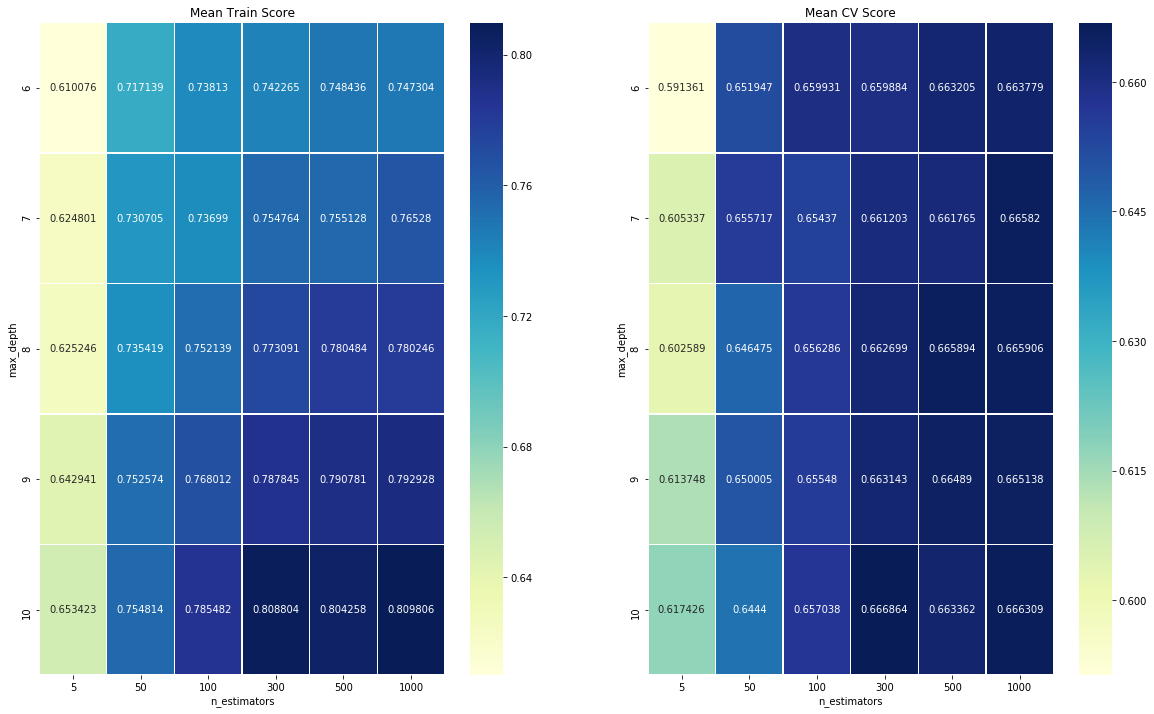

In [12]:
print("Best Hyperparameter for Bag of Words: "+ str(best_hyperparameter_bow))
print("Best Score for Bag of Words: "+ str(best_score_bow))
auc_score_plot(results_bow)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
rf_classifier(best_estimator_bow, X_tr_bow, y_train_bow, X_test_bow, y_test_bow, 'bow_auc_score.pickle')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow_auc_score.pickle', 'rb') as f:
    tr_fpr_bow, tr_tpr_bow, tr_auc_bow, y_tr_predict_bow, te_fpr_bow, te_tpr_bow, te_auc_bow, y_te_predict_bow = pickle.load(f)

#### Plotting ROC curve

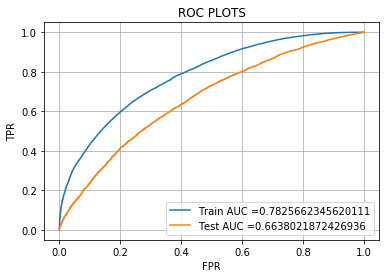

In [15]:
roc_plot(tr_fpr_bow, tr_tpr_bow, tr_auc_bow, te_fpr_bow, te_tpr_bow, te_auc_bow)

#### Train confusion matrix

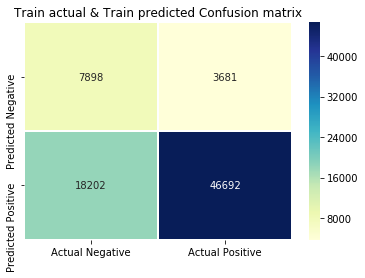

In [17]:
train_conf(y_train_bow, y_tr_predict_bow)

#### Test confusion matrix

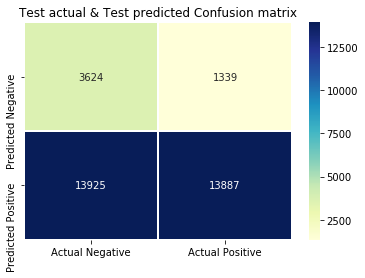

In [18]:
test_conf(y_test_bow, y_te_predict_bow)

## Set 2 - TFIDF

#### Opening TFIDF variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'rb') as f:
    X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_rf(X_tr_tfidf, y_train_tfidf, 'tfidf_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_grid_s_results.pickle', 'rb') as f:
    results_tfidf, best_hyperparameter_tfidf, best_score_tfidf, best_estimator_tfidf = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for TFIDF: {'max_depth': 9, 'n_estimators': 500}
Best Score for TFIDF: 0.6754004498891214


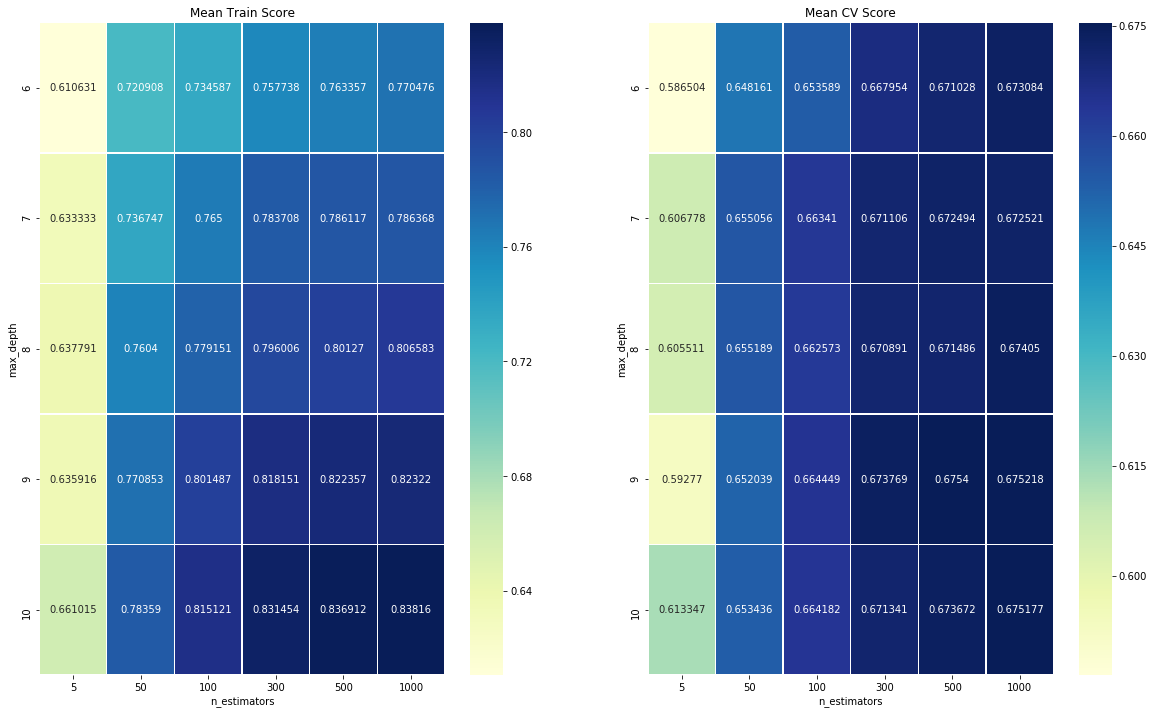

In [12]:
print("Best Hyperparameter for TFIDF: "+ str(best_hyperparameter_tfidf))
print("Best Score for TFIDF: "+ str(best_score_tfidf))
auc_score_plot(results_tfidf)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
rf_classifier(best_estimator_tfidf, X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, 'tfidf_auc_score.pickle')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_auc_score.pickle', 'rb') as f:
    train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, y_train_predict_tfidf, test_fpr_tfidf, test_tpr_tfidf, \
    test_auc_tfidf, y_test_predict_tfidf = pickle.load(f)

#### Plotting ROC curve

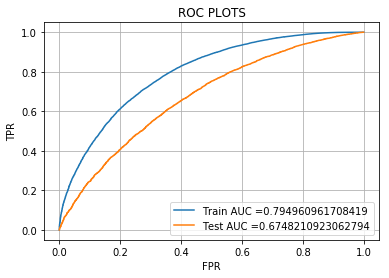

In [15]:
roc_plot(train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, test_fpr_tfidf, test_tpr_tfidf, test_auc_tfidf)

#### Train confusion matrix

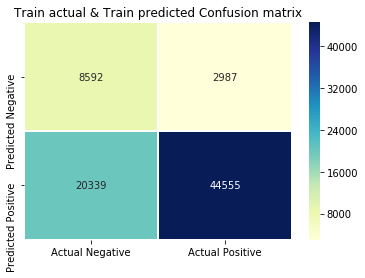

In [16]:
train_conf(y_train_tfidf, y_train_predict_tfidf)

#### Test confusion matrix

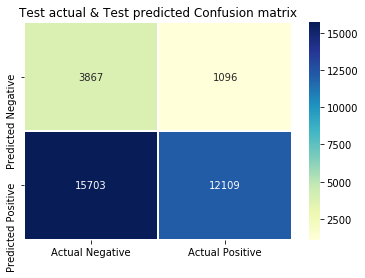

In [17]:
test_conf(y_test_tfidf, y_test_predict_tfidf)

## Set 3 - Avg W2V

#### Opening Avg W2V variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'rb') as f:
    X_tr_avgword2vec, y_train_avgword2vec, X_test_avgword2vec, y_test_avgword2vec = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_rf(X_tr_avgword2vec, y_train_avgword2vec, 'avgword2vec_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('avgword2vec_grid_s_results.pickle', 'rb') as f:
    results_avgword2vec, best_hyperparameter_avgword2vec, best_score_avgword2vec, best_estimator_avgword2vec = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for TFIDF: {'n_estimators': 1000, 'max_depth': 10}
Best Score for TFIDF: 0.6747688060293178


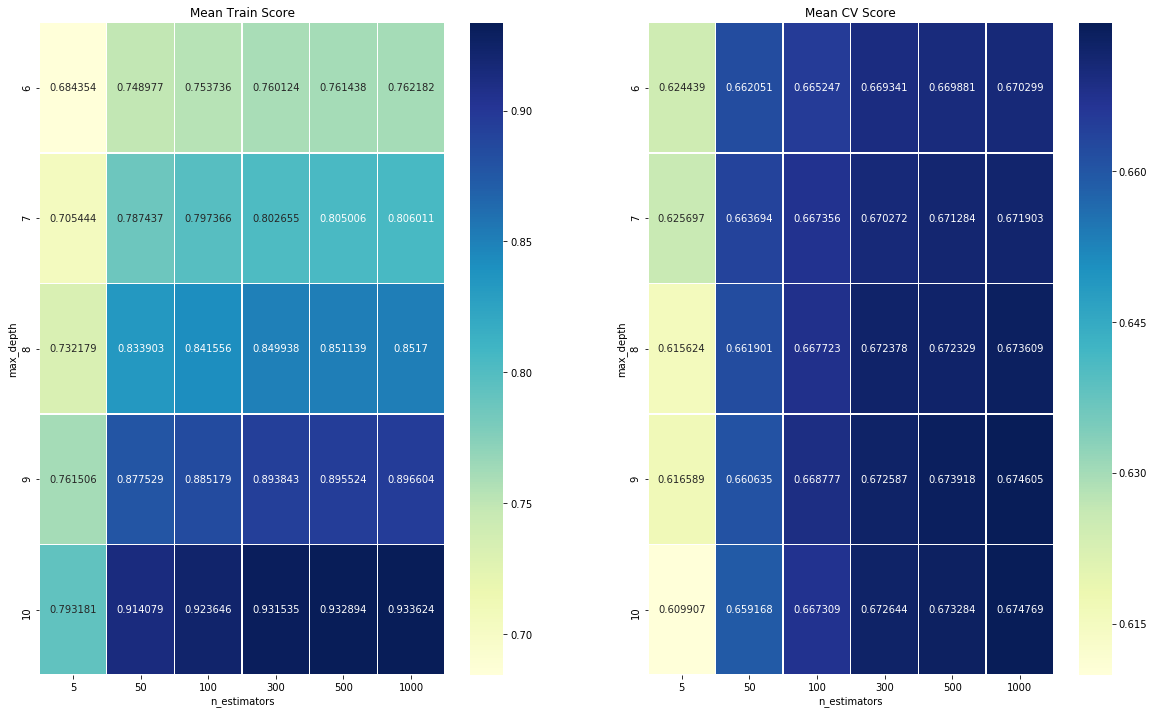

In [12]:
print("Best Hyperparameter for TFIDF: "+ str(best_hyperparameter_avgword2vec))
print("Best Score for TFIDF: "+ str(best_score_avgword2vec))
auc_score_plot(results_avgword2vec)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
rf_classifier(best_estimator_avgword2vec, X_tr_avgword2vec, y_train_avgword2vec, X_test_avgword2vec, y_test_avgword2vec, 'avgword2vec_auc_score.pickle')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec_auc_score.pickle', 'rb') as f:
    train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, y_train_predict_avgword2vec, test_fpr_avgword2vec, \
    test_tpr_avgword2vec, test_auc_avgword2vec, y_test_predict_avgword2vec = pickle.load(f)
    

#### Plotting ROC curve

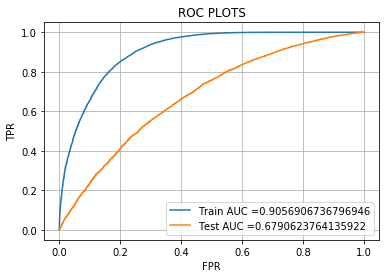

In [15]:
roc_plot(train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, test_fpr_avgword2vec, \
         test_tpr_avgword2vec, test_auc_avgword2vec)

#### Train confusion matrix

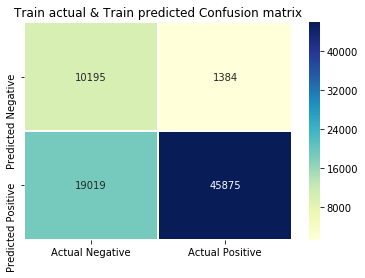

In [16]:
train_conf(y_train_avgword2vec, y_train_predict_avgword2vec)

#### Test confusion matrix

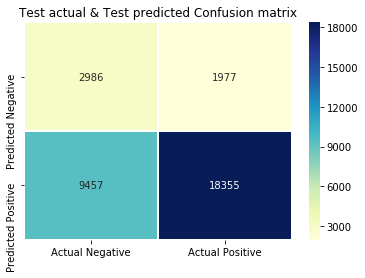

In [17]:
test_conf(y_test_avgword2vec, y_test_predict_avgword2vec)

## Set 4 - TFIDF W2V

#### Opening TFIDF W2V variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, y_test_tfidf_w2v = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_rf(X_tr_tfidf_w2v, y_train_tfidf_w2v, 'tfidf_w2v_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_w2v_grid_s_results.pickle', 'rb') as f:
    results_tfidf_w2v, best_hyperparameter_tfidf_w2v, best_score_tfidf_w2v, best_estimator_tfidf_w2v = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for Bag of Words: {'n_estimators': 1000, 'max_depth': 10}
Best Score for Bag of Words: 0.6824191696543769


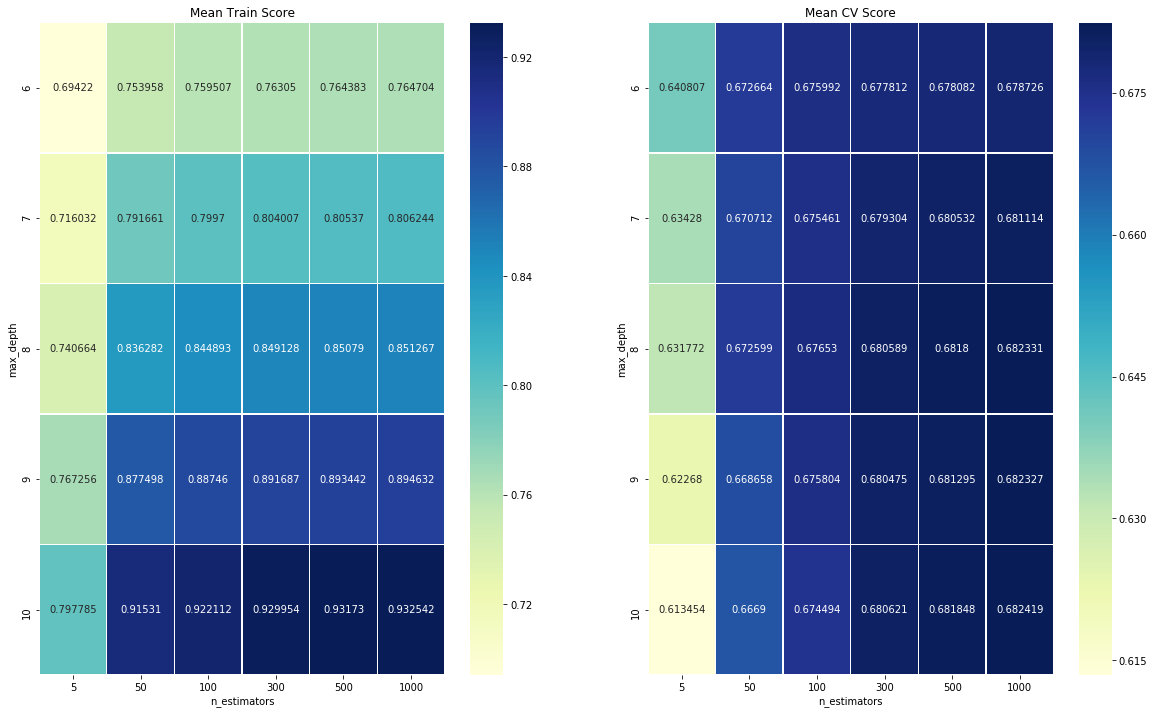

In [12]:
print("Best Hyperparameter for Bag of Words: "+ str(best_hyperparameter_tfidf_w2v))
print("Best Score for Bag of Words: "+ str(best_score_tfidf_w2v))
auc_score_plot(results_tfidf_w2v)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
rf_classifier(best_estimator_tfidf_w2v, X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, \
              y_test_tfidf_w2v, 'tfidf_w2v_auc_score.pickle')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v_auc_score.pickle', 'rb') as f:
    tr_fpr_tfidf_w2v, tr_tpr_tfidf_w2v, tr_auc_tfidf_w2v, y_tr_predict_tfidf_w2v, te_fpr_tfidf_w2v, te_tpr_tfidf_w2v, \
    te_auc_tfidf_w2v, y_te_predict_tfidf_w2v = pickle.load(f)
    

#### Plotting ROC curve

In [15]:
roc_plot(tr_fpr_tfidf_w2v, tr_tpr_tfidf_w2v, tr_auc_tfidf_w2v, te_fpr_tfidf_w2v, te_tpr_tfidf_w2v, te_auc_tfidf_w2v)

#### Train confusion matrix

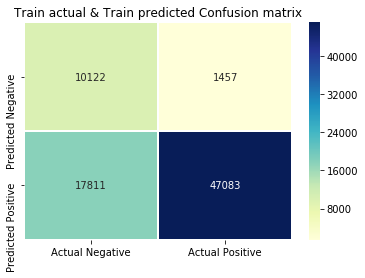

In [16]:
train_conf(y_train_tfidf_w2v, y_tr_predict_tfidf_w2v)

#### Test confusion matrix

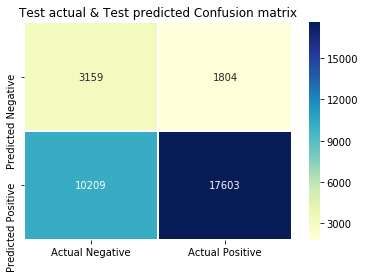

In [17]:
test_conf(y_test_tfidf_w2v, y_te_predict_tfidf_w2v)

# XGBoost Results

## Set 1 - Bag of Words

#### Opening BOW variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'rb') as f:
    X_tr_bow, y_train_bow, X_test_bow, y_test_bow = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_xgb(X_tr_bow, y_train_bow, 'bow_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('bow_grid_s_results.pickle', 'rb') as f:
    results_bow, best_hyperparameter_bow, best_score_bow, best_estimator_bow = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for Bag of Words: {'max_depth': 3, 'n_estimators': 1000}
Best Score for Bag of Words: 0.7212600784643087


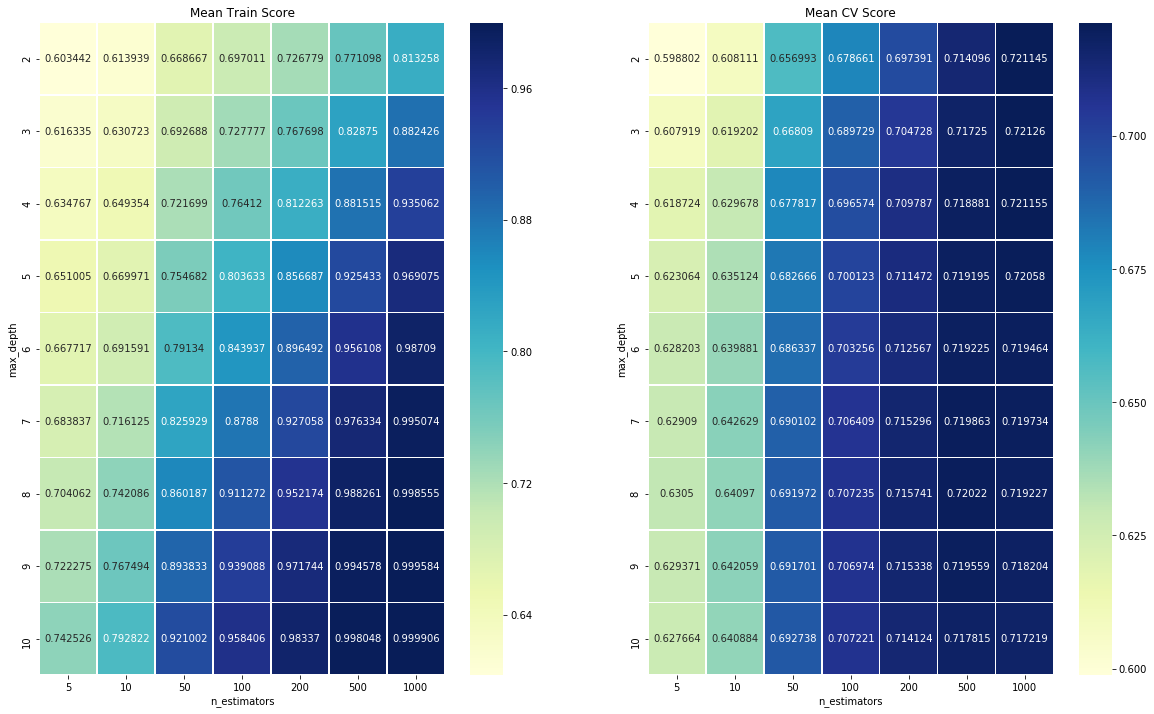

In [12]:
print("Best Hyperparameter for Bag of Words: "+ str(best_hyperparameter_bow))
print("Best Score for Bag of Words: "+ str(best_score_bow))
auc_score_plot(results_bow)

#### Running XGBClassifier on best hyperparameters

In [13]:
xgb_classifier(best_estimator_bow, X_tr_bow, y_train_bow, X_test_bow, y_test_bow, 'bow_auc_score.pickle')

#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow_auc_score.pickle', 'rb') as f:
    tr_fpr_bow, tr_tpr_bow, tr_auc_bow, y_tr_predict_bow, te_fpr_bow, te_tpr_bow, te_auc_bow, y_te_predict_bow = pickle.load(f)

#### Plotting ROC curve

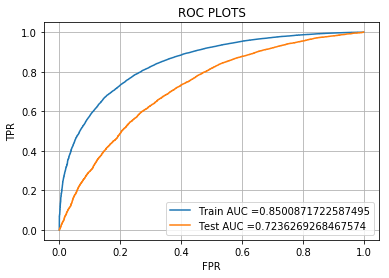

In [15]:
roc_plot(tr_fpr_bow, tr_tpr_bow, tr_auc_bow, te_fpr_bow, te_tpr_bow, te_auc_bow)

#### Train confusion matrix

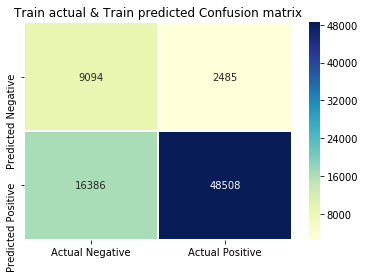

In [16]:
train_conf(y_train_bow, y_tr_predict_bow)

#### Test confusion matrix

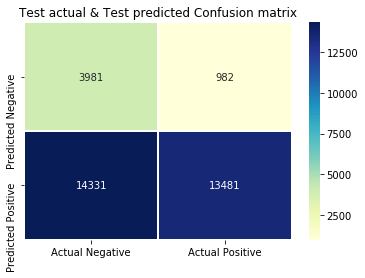

In [17]:
test_conf(y_test_bow, y_te_predict_bow)

## Set 2 - TFIDF

#### Opening TFIDF variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'rb') as f:
    X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_xgb(X_tr_tfidf, y_train_tfidf, 'tfidf_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_grid_s_results.pickle', 'rb') as f:
    results_tfidf, best_hyperparameter_tfidf, best_score_tfidf, best_estimator_tfidf = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for TFIDF: {'max_depth': 2, 'n_estimators': 1000}
Best Score for TFIDF: 0.7176772325774284


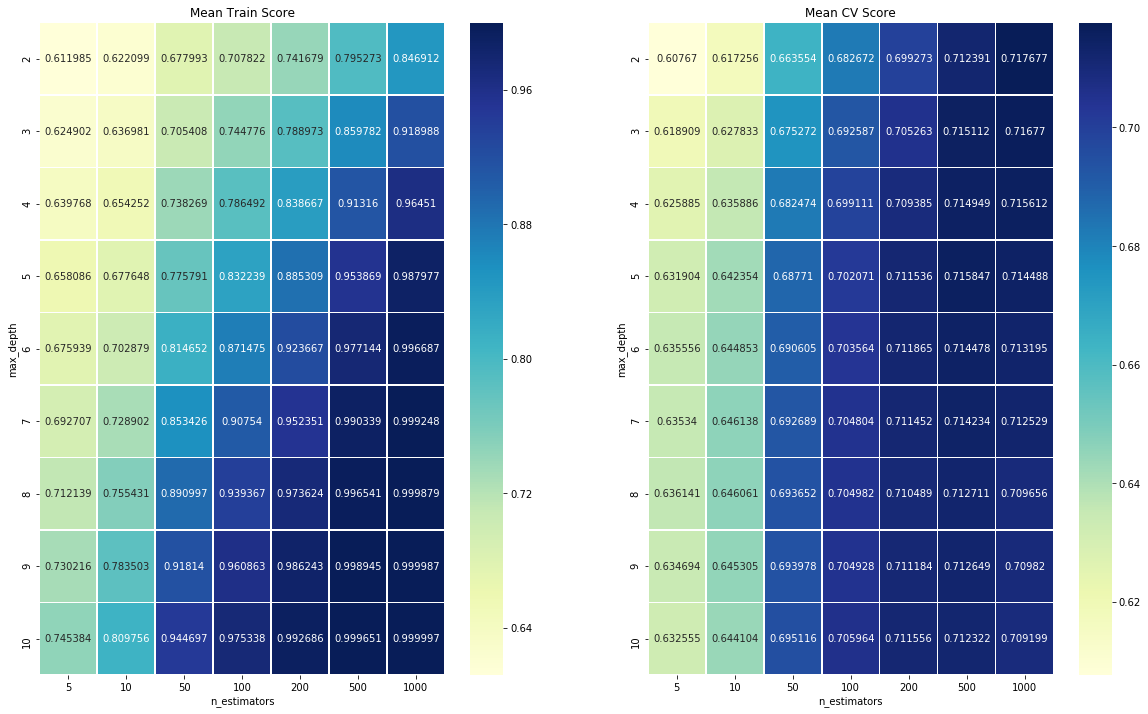

In [12]:
print("Best Hyperparameter for TFIDF: "+ str(best_hyperparameter_tfidf))
print("Best Score for TFIDF: "+ str(best_score_tfidf))
auc_score_plot(results_tfidf)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
xgb_classifier(best_estimator_tfidf, X_tr_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, 'tfidf_auc_score.pickle')

#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_auc_score.pickle', 'rb') as f:
    train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, y_train_predict_tfidf, test_fpr_tfidf, test_tpr_tfidf, \
    test_auc_tfidf, y_test_predict_tfidf = pickle.load(f)

#### Plotting ROC curve

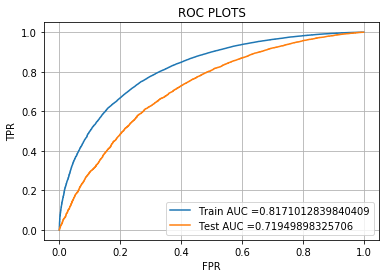

In [15]:
roc_plot(train_fpr_tfidf, train_tpr_tfidf, train_auc_tfidf, test_fpr_tfidf, test_tpr_tfidf, test_auc_tfidf)

#### Train confusion matrix

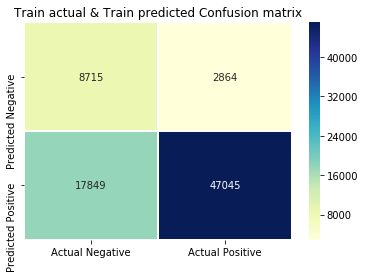

In [16]:
train_conf(y_train_tfidf, y_train_predict_tfidf)

#### Test confusion matrix

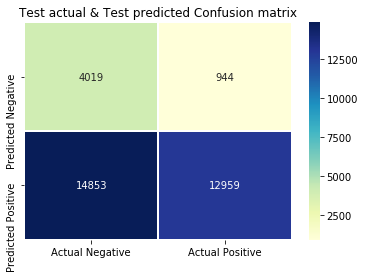

In [17]:
test_conf(y_test_tfidf, y_test_predict_tfidf)

## Set 3 - Avg W2V

#### Opening Avg W2V variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'rb') as f:
    X_tr_avgword2vec, y_train_avgword2vec, X_test_avgword2vec, y_test_avgword2vec = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_xgb(X_tr_avgword2vec, y_train_avgword2vec, 'avgword2vec_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('avgword2vec_grid_s_results.pickle', 'rb') as f:
    results_avgword2vec, best_hyperparameter_avgword2vec, best_score_avgword2vec, best_estimator_avgword2vec = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for TFIDF: {'max_depth': 10, 'n_estimators': 1000}
Best Score for TFIDF: 0.700689762150783


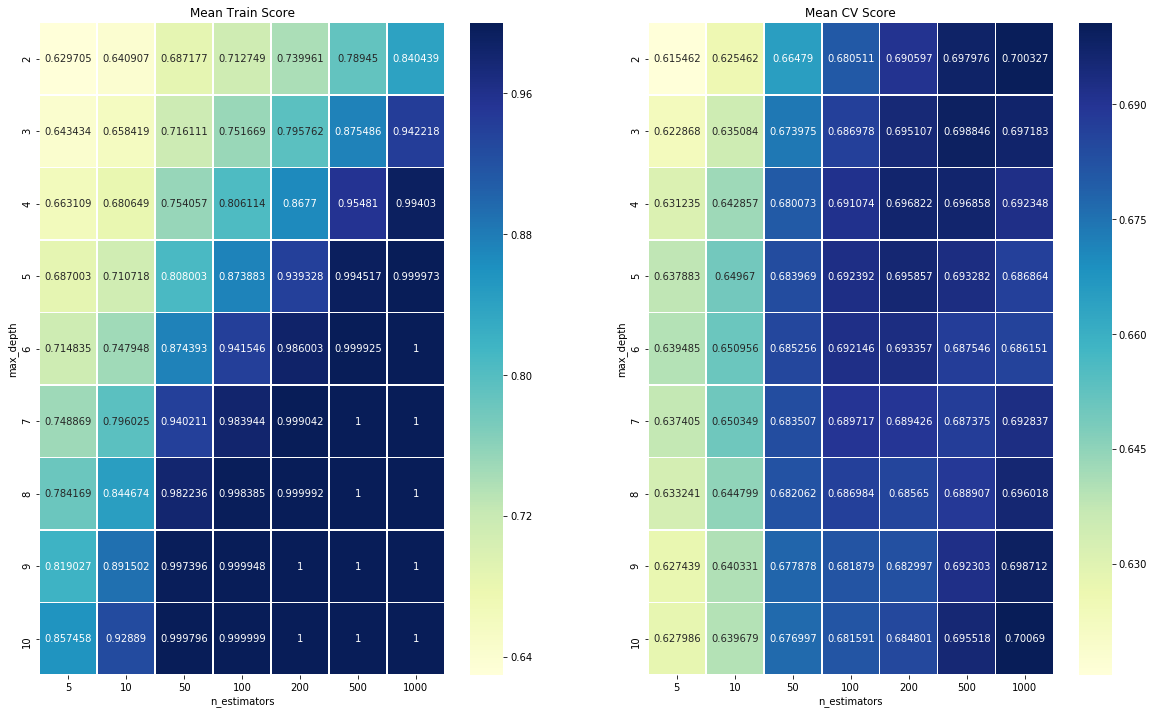

In [12]:
print("Best Hyperparameter for TFIDF: "+ str(best_hyperparameter_avgword2vec))
print("Best Score for TFIDF: "+ str(best_score_avgword2vec))
auc_score_plot(results_avgword2vec)

#### Running XGBClassifier on best hyperparameters

In [13]:
xgb_classifier(best_estimator_avgword2vec, X_tr_avgword2vec, y_train_avgword2vec, X_test_avgword2vec, y_test_avgword2vec, 'avgword2vec_auc_score.pickle')


#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec_auc_score.pickle', 'rb') as f:
    train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, y_train_predict_avgword2vec, test_fpr_avgword2vec, \
    test_tpr_avgword2vec, test_auc_avgword2vec, y_test_predict_avgword2vec = pickle.load(f)
    

#### Plotting ROC curve

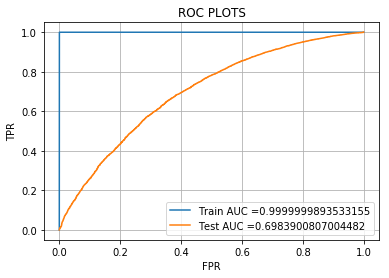

In [15]:
roc_plot(train_fpr_avgword2vec, train_tpr_avgword2vec, train_auc_avgword2vec, test_fpr_avgword2vec, \
         test_tpr_avgword2vec, test_auc_avgword2vec)

#### Train confusion matrix

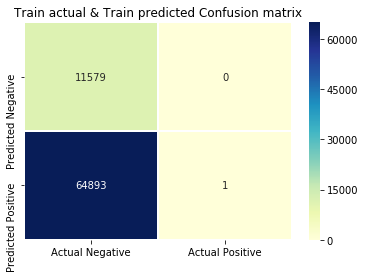

In [16]:
train_conf(y_train_avgword2vec, y_train_predict_avgword2vec)

#### Test confusion matrix

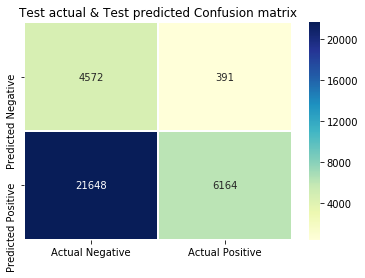

In [17]:
test_conf(y_test_avgword2vec, y_test_predict_avgword2vec)

## Set 4 - TFIDF W2V

#### Opening TFIDF W2V variables

In [9]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, y_test_tfidf_w2v = pickle.load(f)

#### Hyperparameter tuning

In [10]:
hparameter_tuning_gbdt(X_tr_tfidf_w2v, y_train_tfidf_w2v, 'tfidf_w2v_grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [11]:
# This file stored the gridsearchcv cv_results_ dictionary as a variable into the pickle.

with open('tfidf_w2v_grid_s_results.pickle', 'rb') as f:
    results_tfidf_w2v, best_hyperparameter_tfidf_w2v, best_score_tfidf_w2v, best_estimator_tfidf_w2v = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

Best Hyperparameter for Bag of Words: {'max_depth': 2, 'n_estimators': 500}
Best Score for Bag of Words: 0.700187097297918


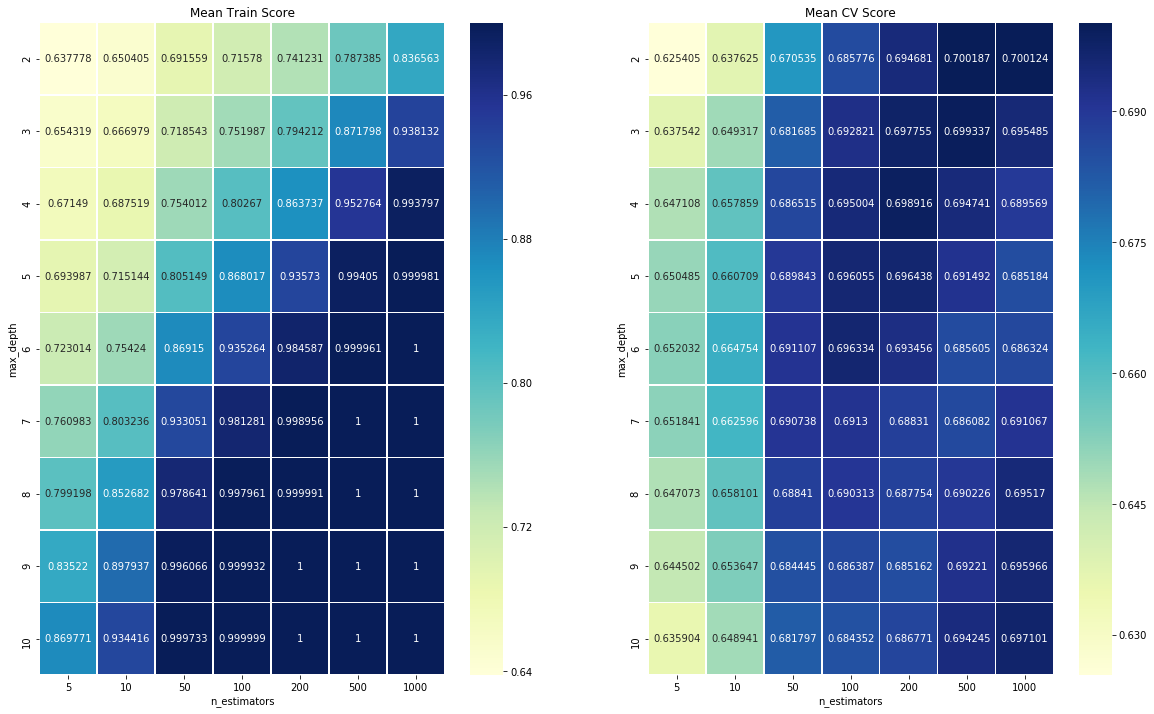

In [12]:
print("Best Hyperparameter for Bag of Words: "+ str(best_hyperparameter_tfidf_w2v))
print("Best Score for Bag of Words: "+ str(best_score_tfidf_w2v))
auc_score_plot(results_tfidf_w2v)

#### Running Random Forest Classifier on best hyperparameters

In [13]:
xgb_classifier(best_estimator_tfidf_w2v, X_tr_tfidf_w2v, y_train_tfidf_w2v, X_test_tfidf_w2v, \
              y_test_tfidf_w2v, 'tfidf_w2v_auc_score.pickle')

#### Opening Random Forest classifier results

In [14]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v_auc_score.pickle', 'rb') as f:
    tr_fpr_tfidf_w2v, tr_tpr_tfidf_w2v, tr_auc_tfidf_w2v, y_tr_predict_tfidf_w2v, te_fpr_tfidf_w2v, te_tpr_tfidf_w2v, \
    te_auc_tfidf_w2v, y_te_predict_tfidf_w2v = pickle.load(f)
    

#### Plotting ROC curve

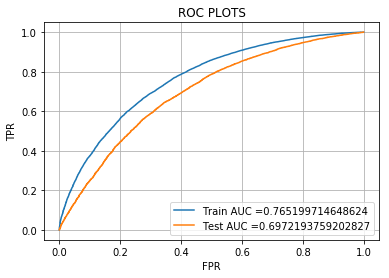

In [15]:
roc_plot(tr_fpr_tfidf_w2v, tr_tpr_tfidf_w2v, tr_auc_tfidf_w2v, te_fpr_tfidf_w2v, te_tpr_tfidf_w2v, te_auc_tfidf_w2v)

#### Train confusion matrix

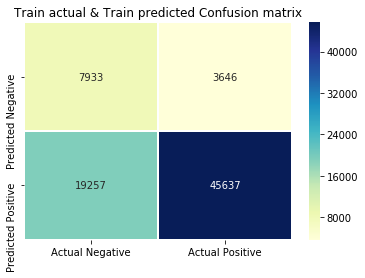

In [16]:
train_conf(y_train_tfidf_w2v, y_tr_predict_tfidf_w2v)

#### Test confusion matrix

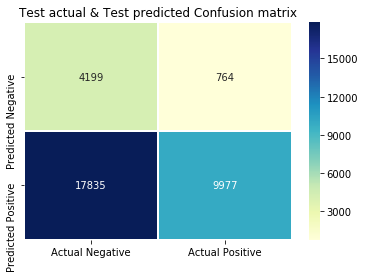

In [17]:
test_conf(y_test_tfidf_w2v, y_te_predict_tfidf_w2v)

# Conclusion

In [1]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "max_depth", "n_estimators", "Best Score", "Train AUC", "Test AUC"]
x.add_row(['BOW', 'Random Forest Classifier', 10, 300, 0.666, 0.782, 0.663])
x.add_row(['BOW', 'XGBoost Classifier', 3, 1000, 0.721, 0.850, 0.723])
x.add_row(['TFIDF', 'Random Forest Classifier',9, 500, 0.675, 0.794, 0.674])
x.add_row(['TFIDF', 'XGBoost Classifier',2, 1000, 0.717, 0.817, 0.719])
x.add_row(['Avg W2V', 'Random Forest Classifier',10, 1000, 0.674, 0.905, 0.679])
x.add_row(['Avg W2V', 'XGBoost Classifier',10, 1000, 0.700, 0.999, 0.698])
x.add_row(['TFIDF W2V', 'Random Forest Classifier',10, 1000, 0.682, 0.999, 0.683])
x.add_row(['TFIDF W2V', 'XGBoost Classifier', 2, 500, 0.700, 0.765, 0.697])
print(x)

+------------+--------------------------+-----------+--------------+------------+-----------+----------+
| Vectorizer |          Model           | max_depth | n_estimators | Best Score | Train AUC | Test AUC |
+------------+--------------------------+-----------+--------------+------------+-----------+----------+
|    BOW     | Random Forest Classifier |     10    |     300      |   0.666    |   0.782   |  0.663   |
|    BOW     |    XGBoost Classifier    |     3     |     1000     |   0.721    |    0.85   |  0.723   |
|   TFIDF    | Random Forest Classifier |     9     |     500      |   0.675    |   0.794   |  0.674   |
|   TFIDF    |    XGBoost Classifier    |     2     |     1000     |   0.717    |   0.817   |  0.719   |
|  Avg W2V   | Random Forest Classifier |     10    |     1000     |   0.674    |   0.905   |  0.679   |
|  Avg W2V   |    XGBoost Classifier    |     10    |     1000     |    0.7     |   0.999   |  0.698   |
| TFIDF W2V  | Random Forest Classifier |     10    |  

# Summary

#### n_estimators
For Gridsearch results of Random Forest Classifier, best hyperparameter n_estimators came out to be 300 for Bag of Words, 500 for TFIDF 1000 for Avg W2V and TFIDF W2V.

For Gridsearch results of XGBoost Classifier's, best hyperparameter n_estimators came out to be 1000 for Bag of Words, TFIDF & Avg W2V and 500 for TFIDF W2V. 

#### max_depth
For Gridsearch results of Random Forest Classifier's Best hyperparameter max_depth came out to be 10 for Bag of Words, 9 for TFIDF, and 10 for Avg W2V and TFIDF W2V.

For Gridsearch results of XGBoost Classifier's Best hyperparameter max_depth came out to be 3 for Bag of Words, 2 for TFIDF & TFIDF W2V, and 10 for Avg W2V.

#### Best Score
For Gridsearch results of Random Forest Classifier's Best score of best hyperparameter grid search for Bag of Words 0.666, for TFIDF 0.675, for Avg W2V 0.674, for TFIDF W2V 0.682.

For Gridsearch results of XGBoost Classifier's Best score of best hyperparameter grid search for Bag of Words 0.721, for TFIDF 0.717, for Avg W2V & TFIDF W2V.

#### Train & Test AUC

1. Bag of Words
    1. For Random Forest's prediction, for Bag of Words Train AUC was 0.782 and Test AUC was 0.663.
    2. For XGBoost Classifier's prediction for Bag of Words Train AUC was 0.85 and Test AUC was 0.723.

2. TFIDF
    1. For Random Forest's prediction, for TFIDF Train AUC was 0.794 and Test AUC was 0.674.
    2. For XGBoost Classifier's prediction for TFIDF Train AUC was 0.817 and Test AUC was 0.719.

3. Avg W2V
    1. For Random Forest's prediction, for Avg W2V Train AUC was 0.905 and Test AUC was 0.679.
    2. For XGBoost Classifier's prediction for Avg W2V Train AUC was 0.999 and Test AUC was 0.698.

4. TFIDF W2V
    1. For Random Forest's prediction, for TFIDF W2V Train AUC was 0.999 and Test AUC was 0.683.
    2. For XGBoost Classifier's prediction for TFIDF W2V Train AUC was 0.765 and Test AUC was 0.697.

At the end, we conclude that XGBoost Classifier's Train AUC was medium-high for all the sets except for Avg W2V. So we got better results for Test set. While level best efforts were tried to increase the AUC score of Test sets of each Bag of Words, TFIDF, Avg W2V and TFIDF W2V for Random Forest Classifier. 

It was difficult to lower down the off diagonal number of data points for each classifier's confusion Matrix for both Train and Test sets.